In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17             

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 245)
(2, 245)


[I 2025-06-08 06:10:00,739] A new study created in memory with name: no-name-a74fdf8e-ba3b-4d5f-b144-cfe0fd4d7140
[I 2025-06-08 06:11:59,298] Trial 0 finished with value: 0.4390038073062897 and parameters: {'lr': 0.0069218411831461395, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1794383855211423}. Best is trial 0 with value: 0.4390038073062897.


Cross Validation Accuracies:
[0.32465094327926636, 0.4052841067314148, 0.5120781064033508, 0.4740171730518341, 0.4789887070655823]
Mean Cross Validation Accuracy:
0.4390038073062897
Standard Deviation of Cross Validation Accuracy:
0.06690018968009104


[I 2025-06-08 06:13:05,332] Trial 1 finished with value: 0.5766124486923218 and parameters: {'lr': 0.0013322065861706037, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.377035904311792}. Best is trial 0 with value: 0.4390038073062897.


Cross Validation Accuracies:
[0.51853346824646, 0.5941025614738464, 0.579664409160614, 0.5868635177612305, 0.603898286819458]
Mean Cross Validation Accuracy:
0.5766124486923218
Standard Deviation of Cross Validation Accuracy:
0.03012636007484836


[I 2025-06-08 06:14:43,452] Trial 2 finished with value: 0.07786114066839218 and parameters: {'lr': 0.002358096811836091, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.41867321989618755}. Best is trial 2 with value: 0.07786114066839218.


Cross Validation Accuracies:
[0.05973023176193237, 0.08662945032119751, 0.08672866970300674, 0.08690792322158813, 0.06930942833423615]
Mean Cross Validation Accuracy:
0.07786114066839218
Standard Deviation of Cross Validation Accuracy:
0.01130683193058535


[I 2025-06-08 06:16:33,975] Trial 3 finished with value: 2.9495352268218995 and parameters: {'lr': 0.032898435361754456, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2060455254255624}. Best is trial 2 with value: 0.07786114066839218.


Cross Validation Accuracies:
[1.5342628955841064, 3.6156458854675293, 3.349383592605591, 3.1601383686065674, 3.088245391845703]
Mean Cross Validation Accuracy:
2.9495352268218995
Standard Deviation of Cross Validation Accuracy:
0.7307765855525155


[I 2025-06-08 06:17:56,668] Trial 4 finished with value: 1.422662726044655 and parameters: {'lr': 0.4165539365657569, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14260079669915005}. Best is trial 2 with value: 0.07786114066839218.


Cross Validation Accuracies:
[0.25019732117652893, 0.2703341543674469, 6.157196044921875, 0.2079295516014099, 0.2276565581560135]
Mean Cross Validation Accuracy:
1.422662726044655
Standard Deviation of Cross Validation Accuracy:
2.367359644695314


[I 2025-06-08 06:21:40,068] Trial 5 finished with value: 0.09651926159858704 and parameters: {'lr': 0.012528634751828844, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4404919546104259}. Best is trial 2 with value: 0.07786114066839218.


Cross Validation Accuracies:
[0.14368389546871185, 0.08617959916591644, 0.10121063888072968, 0.08028153330087662, 0.07124064117670059]
Mean Cross Validation Accuracy:
0.09651926159858704
Standard Deviation of Cross Validation Accuracy:
0.0255189843012295


[I 2025-06-08 06:27:09,336] Trial 6 finished with value: 0.08556726276874542 and parameters: {'lr': 0.001893556259921701, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2274573730604068}. Best is trial 2 with value: 0.07786114066839218.


Cross Validation Accuracies:
[0.1253080666065216, 0.05891871452331543, 0.10247742384672165, 0.06949247419834137, 0.07163963466882706]
Mean Cross Validation Accuracy:
0.08556726276874542
Standard Deviation of Cross Validation Accuracy:
0.02460816048800701


[I 2025-06-08 06:33:32,525] Trial 7 finished with value: 0.11138297468423844 and parameters: {'lr': 0.24749711149953052, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2286703372921644}. Best is trial 2 with value: 0.07786114066839218.


Cross Validation Accuracies:
[0.09531815350055695, 0.11456690728664398, 0.1394737958908081, 0.09009610861539841, 0.11745990812778473]
Mean Cross Validation Accuracy:
0.11138297468423844
Standard Deviation of Cross Validation Accuracy:
0.01759187272378817


[I 2025-06-08 06:40:29,378] Trial 8 finished with value: 0.09924964308738708 and parameters: {'lr': 0.052111667503104316, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.20776749794684068}. Best is trial 2 with value: 0.07786114066839218.


Cross Validation Accuracies:
[0.15207302570343018, 0.08644653856754303, 0.09924964606761932, 0.08270592242479324, 0.07577308267354965]
Mean Cross Validation Accuracy:
0.09924964308738708
Standard Deviation of Cross Validation Accuracy:
0.02749208183667958


[I 2025-06-08 06:46:09,989] Trial 9 finished with value: 0.06764219105243682 and parameters: {'lr': 0.0019284334510804974, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1563549707675548}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.07863017916679382, 0.07368949055671692, 0.0541103295981884, 0.057918380945920944, 0.07386257499456406]
Mean Cross Validation Accuracy:
0.06764219105243682
Standard Deviation of Cross Validation Accuracy:
0.009733063730272662


[I 2025-06-08 06:52:01,530] Trial 10 finished with value: 0.8550159990787506 and parameters: {'lr': 0.10542719869303402, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3045220708292118}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.7507250308990479, 0.6662759780883789, 1.0286009311676025, 1.3568809032440186, 0.4725971519947052]
Mean Cross Validation Accuracy:
0.8550159990787506
Standard Deviation of Cross Validation Accuracy:
0.3081375299613798


[I 2025-06-08 06:58:23,456] Trial 11 finished with value: 0.0723046287894249 and parameters: {'lr': 0.004754812919293459, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4725137910543102}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.05929628759622574, 0.08380277454853058, 0.07824400067329407, 0.08234008401632309, 0.05783999711275101]
Mean Cross Validation Accuracy:
0.0723046287894249
Standard Deviation of Cross Validation Accuracy:
0.011372214964765075


[I 2025-06-08 07:05:07,627] Trial 12 finished with value: 0.08841474652290345 and parameters: {'lr': 0.006730728888309222, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.10411109164020937}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.06785556674003601, 0.0856078490614891, 0.11366701871156693, 0.10739792883396149, 0.06754536926746368]
Mean Cross Validation Accuracy:
0.08841474652290345
Standard Deviation of Cross Validation Accuracy:
0.019308691903276307


[I 2025-06-08 07:10:26,394] Trial 13 finished with value: 0.07943618148565293 and parameters: {'lr': 0.004512502087784759, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.33408154128725}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.07894488424062729, 0.06280636042356491, 0.09909404069185257, 0.08298972249031067, 0.07334589958190918]
Mean Cross Validation Accuracy:
0.07943618148565293
Standard Deviation of Cross Validation Accuracy:
0.011941046331454012


[I 2025-06-08 07:15:59,623] Trial 14 finished with value: 0.06828063055872917 and parameters: {'lr': 0.0010241714602555233, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4904607699947501}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.059557002037763596, 0.06620880216360092, 0.0639088824391365, 0.0790489986538887, 0.07267946749925613]
Mean Cross Validation Accuracy:
0.06828063055872917
Standard Deviation of Cross Validation Accuracy:
0.0068529390330575694


[I 2025-06-08 07:22:13,957] Trial 15 finished with value: 0.07470790296792984 and parameters: {'lr': 0.0011764744036113974, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2732018004934823}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.0707852840423584, 0.08236842602491379, 0.06706877052783966, 0.0878480076789856, 0.06546902656555176]
Mean Cross Validation Accuracy:
0.07470790296792984
Standard Deviation of Cross Validation Accuracy:
0.008836810354137971


[I 2025-06-08 07:27:49,030] Trial 16 finished with value: 0.11768548935651779 and parameters: {'lr': 0.01811999375453837, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.49755140403802756}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.1603030264377594, 0.10581059008836746, 0.12590597569942474, 0.12431108206510544, 0.07209677249193192]
Mean Cross Validation Accuracy:
0.11768548935651779
Standard Deviation of Cross Validation Accuracy:
0.028799561383163832


[I 2025-06-08 07:33:46,446] Trial 17 finished with value: 0.09033244103193283 and parameters: {'lr': 0.0010081382373880211, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.36526131918753024}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.14193324744701385, 0.08421695977449417, 0.06660715490579605, 0.0814206600189209, 0.07748418301343918]
Mean Cross Validation Accuracy:
0.09033244103193283
Standard Deviation of Cross Validation Accuracy:
0.026485577624048434


[I 2025-06-08 07:39:26,205] Trial 18 finished with value: 0.18268012702465058 and parameters: {'lr': 0.00360079898512761, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.10449792729801571}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.18896159529685974, 0.14360591769218445, 0.20245973765850067, 0.20473220944404602, 0.173641175031662]
Mean Cross Validation Accuracy:
0.18268012702465058
Standard Deviation of Cross Validation Accuracy:
0.0224743438952163


[I 2025-06-08 07:45:51,897] Trial 19 finished with value: 0.3489460587501526 and parameters: {'lr': 0.015019338861610916, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2970823942781361}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.32092154026031494, 0.4085564911365509, 0.372791588306427, 0.2680329382419586, 0.3744277358055115]
Mean Cross Validation Accuracy:
0.3489460587501526
Standard Deviation of Cross Validation Accuracy:
0.049200885157945885


[I 2025-06-08 07:52:05,077] Trial 20 finished with value: 0.09805504232645035 and parameters: {'lr': 0.0025295137125855567, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.26177826602398263}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.14430105686187744, 0.08912000805139542, 0.0956738069653511, 0.08301141113042831, 0.07816892862319946]
Mean Cross Validation Accuracy:
0.09805504232645035
Standard Deviation of Cross Validation Accuracy:
0.023857775828994787


[I 2025-06-08 07:58:10,353] Trial 21 finished with value: 0.10625785738229751 and parameters: {'lr': 0.005192830324808048, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.49637195328865474}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.1773054599761963, 0.07958514243364334, 0.08071666210889816, 0.12489430606365204, 0.06878771632909775]
Mean Cross Validation Accuracy:
0.10625785738229751
Standard Deviation of Cross Validation Accuracy:
0.04040514052213183


[I 2025-06-08 08:04:37,556] Trial 22 finished with value: 0.09286369830369949 and parameters: {'lr': 0.0024795076295919057, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4445289757765586}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.1251663863658905, 0.0861271396279335, 0.10048801451921463, 0.07777805626392365, 0.07475889474153519]
Mean Cross Validation Accuracy:
0.09286369830369949
Standard Deviation of Cross Validation Accuracy:
0.018451751051681967


[I 2025-06-08 08:10:36,541] Trial 23 finished with value: 0.08469514548778534 and parameters: {'lr': 0.0010058953018605894, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.45412251500945705}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.1265634149312973, 0.07531731575727463, 0.07018860429525375, 0.07964792102575302, 0.07175847142934799]
Mean Cross Validation Accuracy:
0.08469514548778534
Standard Deviation of Cross Validation Accuracy:
0.021185690569268528


[I 2025-06-08 08:16:40,363] Trial 24 finished with value: 0.08522024303674698 and parameters: {'lr': 0.008553039758220518, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4076275830831183}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.08324232697486877, 0.11399783194065094, 0.05703934282064438, 0.09987591952085495, 0.07194579392671585]
Mean Cross Validation Accuracy:
0.08522024303674698
Standard Deviation of Cross Validation Accuracy:
0.020085939183625473


[I 2025-06-08 08:22:30,126] Trial 25 finished with value: 0.07373571246862412 and parameters: {'lr': 0.0018810744981535095, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4715551598542668}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.09634897112846375, 0.06832044571638107, 0.06825154274702072, 0.07463060319423676, 0.06112699955701828]
Mean Cross Validation Accuracy:
0.07373571246862412
Standard Deviation of Cross Validation Accuracy:
0.012087523894066936


[I 2025-06-08 08:28:19,481] Trial 26 finished with value: 0.09401259571313858 and parameters: {'lr': 0.0034272979193991134, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.37763270277281036}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.14375750720500946, 0.07046322524547577, 0.10678403079509735, 0.07801345735788345, 0.07104475796222687]
Mean Cross Validation Accuracy:
0.09401259571313858
Standard Deviation of Cross Validation Accuracy:
0.028198342582048275


[I 2025-06-08 08:34:12,242] Trial 27 finished with value: 0.10136181265115737 and parameters: {'lr': 0.02632777788738684, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.41056193447234457}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.14284659922122955, 0.08750487118959427, 0.1005653515458107, 0.08262553811073303, 0.09326670318841934]
Mean Cross Validation Accuracy:
0.10136181265115737
Standard Deviation of Cross Validation Accuracy:
0.0215880312886276


[I 2025-06-08 08:40:27,854] Trial 28 finished with value: 0.1362981006503105 and parameters: {'lr': 0.009749746699700117, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.34286492129393353}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.16786642372608185, 0.10706924647092819, 0.11923027783632278, 0.10731460899114609, 0.18000994622707367]
Mean Cross Validation Accuracy:
0.1362981006503105
Standard Deviation of Cross Validation Accuracy:
0.03128246712313207


[I 2025-06-08 08:46:25,761] Trial 29 finished with value: 0.09600785970687867 and parameters: {'lr': 0.005897829391926829, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1590264409649043}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.14238093793392181, 0.08674337714910507, 0.09956160187721252, 0.08008480817079544, 0.07126857340335846]
Mean Cross Validation Accuracy:
0.09600785970687867
Standard Deviation of Cross Validation Accuracy:
0.024957956493896965


[I 2025-06-08 08:53:10,223] Trial 30 finished with value: 0.12126122117042541 and parameters: {'lr': 0.0018102917559324437, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.48172823588332847}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.18236033618450165, 0.10057146847248077, 0.13197164237499237, 0.11503352224826813, 0.07636913657188416]
Mean Cross Validation Accuracy:
0.12126122117042541
Standard Deviation of Cross Validation Accuracy:
0.035580793521371286


[I 2025-06-08 08:59:25,442] Trial 31 finished with value: 0.07805911600589752 and parameters: {'lr': 0.0016757377648843573, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4646106173389031}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.08732495456933975, 0.08729878813028336, 0.06552272289991379, 0.08708532154560089, 0.06306379288434982]
Mean Cross Validation Accuracy:
0.07805911600589752
Standard Deviation of Cross Validation Accuracy:
0.011266947761681306


[I 2025-06-08 09:05:07,160] Trial 32 finished with value: 0.0852548211812973 and parameters: {'lr': 0.003390715293148862, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4750536151336794}. Best is trial 9 with value: 0.06764219105243682.


Cross Validation Accuracies:
[0.07824110984802246, 0.085337795317173, 0.10376100987195969, 0.08797935396432877, 0.0709548369050026]
Mean Cross Validation Accuracy:
0.0852548211812973
Standard Deviation of Cross Validation Accuracy:
0.010987180533842353


[I 2025-06-08 09:10:43,843] Trial 33 finished with value: 0.06320660784840584 and parameters: {'lr': 0.0014959857812542297, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4157929071075198}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.06348669528961182, 0.07208423316478729, 0.05980008840560913, 0.06430864334106445, 0.0563533790409565]
Mean Cross Validation Accuracy:
0.06320660784840584
Standard Deviation of Cross Validation Accuracy:
0.005266427294879576


[I 2025-06-08 09:16:44,468] Trial 34 finished with value: 0.07852646633982659 and parameters: {'lr': 0.0016354286903543227, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.43176707320938434}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.0745127946138382, 0.10093633085489273, 0.060468751937150955, 0.08786483108997345, 0.06884962320327759]
Mean Cross Validation Accuracy:
0.07852646633982659
Standard Deviation of Cross Validation Accuracy:
0.014319490123970052


[I 2025-06-08 09:22:45,688] Trial 35 finished with value: 0.08194911479949951 and parameters: {'lr': 0.0029144738732373244, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4107643589578147}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.08209943026304245, 0.08884526789188385, 0.09166335314512253, 0.08088915050029755, 0.06624837219715118]
Mean Cross Validation Accuracy:
0.08194911479949951
Standard Deviation of Cross Validation Accuracy:
0.00882703564543084


[I 2025-06-08 09:29:14,010] Trial 36 finished with value: 0.10160796493291854 and parameters: {'lr': 0.862594837485005, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3722352168778514}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.13478077948093414, 0.08244640380144119, 0.0982353612780571, 0.0966181829571724, 0.09595909714698792]
Mean Cross Validation Accuracy:
0.10160796493291854
Standard Deviation of Cross Validation Accuracy:
0.017525884496216275


[I 2025-06-08 09:34:28,732] Trial 37 finished with value: 0.18933842182159424 and parameters: {'lr': 0.0014294380596342263, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3854559419098745}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.2804436683654785, 0.18003833293914795, 0.20007576048374176, 0.13274240493774414, 0.15339194238185883]
Mean Cross Validation Accuracy:
0.18933842182159424
Standard Deviation of Cross Validation Accuracy:
0.05098471644290542


[I 2025-06-08 09:39:33,510] Trial 38 finished with value: 0.08570129871368408 and parameters: {'lr': 0.00406071977966194, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.43213052620551445}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.14010590314865112, 0.07143235206604004, 0.06806375086307526, 0.08275704085826874, 0.06614744663238525]
Mean Cross Validation Accuracy:
0.08570129871368408
Standard Deviation of Cross Validation Accuracy:
0.027804922952159222


[I 2025-06-08 09:45:59,160] Trial 39 finished with value: 0.09857610315084457 and parameters: {'lr': 0.059611474130319274, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.17802196246071972}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.1435156762599945, 0.08559093624353409, 0.10105843842029572, 0.0806451067328453, 0.08207035809755325]
Mean Cross Validation Accuracy:
0.09857610315084457
Standard Deviation of Cross Validation Accuracy:
0.023614834454384212


[I 2025-06-08 09:51:04,650] Trial 40 finished with value: 0.09651396423578262 and parameters: {'lr': 0.002458628977333194, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.49726989459694826}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.1436949223279953, 0.08631769567728043, 0.10122877359390259, 0.08014221489429474, 0.07118621468544006]
Mean Cross Validation Accuracy:
0.09651396423578262
Standard Deviation of Cross Validation Accuracy:
0.02554120279111785


[I 2025-06-08 09:56:22,533] Trial 41 finished with value: 0.06845131143927574 and parameters: {'lr': 0.001402293401866186, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4689819950327853}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.06246728077530861, 0.09122980386018753, 0.05429999530315399, 0.07204656302928925, 0.06221291422843933]
Mean Cross Validation Accuracy:
0.06845131143927574
Standard Deviation of Cross Validation Accuracy:
0.012702531417768356


[I 2025-06-08 10:01:49,280] Trial 42 finished with value: 0.06938793882727623 and parameters: {'lr': 0.001365304015268886, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4546100102588202}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.061188094317913055, 0.0685199573636055, 0.05825075879693031, 0.09495577961206436, 0.06402510404586792]
Mean Cross Validation Accuracy:
0.06938793882727623
Standard Deviation of Cross Validation Accuracy:
0.01322499225040456


[I 2025-06-08 10:07:19,166] Trial 43 finished with value: 0.07043304070830345 and parameters: {'lr': 0.0013140062228796784, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4507026496257193}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.05738115683197975, 0.062354926019907, 0.05625195428729057, 0.11242883652448654, 0.0637483298778534]
Mean Cross Validation Accuracy:
0.07043304070830345
Standard Deviation of Cross Validation Accuracy:
0.0211898232500483


[I 2025-06-08 10:12:39,808] Trial 44 finished with value: 0.08755203187465668 and parameters: {'lr': 0.0021201753100374785, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3934963241271937}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.11579839885234833, 0.09091849625110626, 0.07616791874170303, 0.0866202786564827, 0.06825506687164307]
Mean Cross Validation Accuracy:
0.08755203187465668
Standard Deviation of Cross Validation Accuracy:
0.016198946780870235


[I 2025-06-08 10:17:50,820] Trial 45 finished with value: 0.07848039269447327 and parameters: {'lr': 0.0013811857616194644, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4289740629812785}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.10960199683904648, 0.06369584798812866, 0.0838153138756752, 0.0665128156542778, 0.06877598911523819]
Mean Cross Validation Accuracy:
0.07848039269447327
Standard Deviation of Cross Validation Accuracy:
0.017046974744843967


[I 2025-06-08 10:22:55,163] Trial 46 finished with value: 0.06787893399596215 and parameters: {'lr': 0.0010064427137935362, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.455258453275828}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.08452294766902924, 0.06488791108131409, 0.061144519597291946, 0.061282433569431305, 0.06755685806274414]
Mean Cross Validation Accuracy:
0.06787893399596215
Standard Deviation of Cross Validation Accuracy:
0.008659553075097932


[I 2025-06-08 10:27:39,805] Trial 47 finished with value: 0.06385457590222358 and parameters: {'lr': 0.0011025561254524318, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1325911205962858}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.05720233917236328, 0.06969805806875229, 0.05614196136593819, 0.0727938860654831, 0.06343663483858109]
Mean Cross Validation Accuracy:
0.06385457590222358
Standard Deviation of Cross Validation Accuracy:
0.006602558613955588


[I 2025-06-08 10:33:12,857] Trial 48 finished with value: 0.06954367905855179 and parameters: {'lr': 0.0021277952678976134, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1274477304413234}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.05338452011346817, 0.06831995397806168, 0.053715839982032776, 0.1006769984960556, 0.07162108272314072]
Mean Cross Validation Accuracy:
0.06954367905855179
Standard Deviation of Cross Validation Accuracy:
0.01724375594759204


[I 2025-06-08 10:38:03,041] Trial 49 finished with value: 0.1302776277065277 and parameters: {'lr': 0.0011062136915081123, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1951606868667464}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.19827309250831604, 0.09697014093399048, 0.10355345159769058, 0.1582409143447876, 0.09435053914785385]
Mean Cross Validation Accuracy:
0.1302776277065277
Standard Deviation of Cross Validation Accuracy:
0.04127869811252869


[I 2025-06-08 10:43:14,520] Trial 50 finished with value: 1.113571572303772 and parameters: {'lr': 0.17068446300911583, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13435418733684842}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.9466242790222168, 1.6009654998779297, 1.2214405536651611, 0.6017278432846069, 1.1970996856689453]
Mean Cross Validation Accuracy:
1.113571572303772
Standard Deviation of Cross Validation Accuracy:
0.33046055896845977


[I 2025-06-08 10:48:13,969] Trial 51 finished with value: 0.07350907474756241 and parameters: {'lr': 0.0010765836780840341, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15979530501770117}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.07750660926103592, 0.0872178003191948, 0.058946747332811356, 0.08197063952684402, 0.06190357729792595]
Mean Cross Validation Accuracy:
0.07350907474756241
Standard Deviation of Cross Validation Accuracy:
0.011155774005300101


[I 2025-06-08 10:53:04,178] Trial 52 finished with value: 0.0706367015838623 and parameters: {'lr': 0.0014882865403078747, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.24867260005235306}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.05970289930701256, 0.0641813650727272, 0.05673598870635033, 0.10019616782665253, 0.07236708700656891]
Mean Cross Validation Accuracy:
0.0706367015838623
Standard Deviation of Cross Validation Accuracy:
0.015692071236608863


[I 2025-06-08 10:58:05,845] Trial 53 finished with value: 0.06779536679387092 and parameters: {'lr': 0.0010142321885856069, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3471706092448069}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.0555385984480381, 0.05683165788650513, 0.06842055171728134, 0.09442311525344849, 0.06376291066408157]
Mean Cross Validation Accuracy:
0.06779536679387092
Standard Deviation of Cross Validation Accuracy:
0.0141146720113684


[I 2025-06-08 11:03:06,050] Trial 54 finished with value: 0.08010681122541427 and parameters: {'lr': 0.002895571423010658, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3456404615309491}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.10437819361686707, 0.09799270331859589, 0.05932258069515228, 0.06678173691034317, 0.07205884158611298]
Mean Cross Validation Accuracy:
0.08010681122541427
Standard Deviation of Cross Validation Accuracy:
0.017795037503267132


[I 2025-06-08 11:08:00,563] Trial 55 finished with value: 0.07471706569194794 and parameters: {'lr': 0.0010612241326724383, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.289794333161449}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.06600003689527512, 0.07817473262548447, 0.07890012860298157, 0.07542809844017029, 0.07508233189582825]
Mean Cross Validation Accuracy:
0.07471706569194794
Standard Deviation of Cross Validation Accuracy:
0.004606062395402434


[I 2025-06-08 11:12:28,150] Trial 56 finished with value: 0.5522686302661896 and parameters: {'lr': 0.0018794585062572944, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.23476415414088514}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.4883440434932709, 0.5604407787322998, 0.5645695328712463, 0.5790776610374451, 0.5689111351966858]
Mean Cross Validation Accuracy:
0.5522686302661896
Standard Deviation of Cross Validation Accuracy:
0.032558089964847034


[I 2025-06-08 11:17:30,947] Trial 57 finished with value: 0.06702596396207809 and parameters: {'lr': 0.0022694337367729278, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.11915782453016108}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.07912155985832214, 0.06345725804567337, 0.05181051045656204, 0.06422477960586548, 0.07651571184396744]
Mean Cross Validation Accuracy:
0.06702596396207809
Standard Deviation of Cross Validation Accuracy:
0.009883836057329686


[I 2025-06-08 11:22:33,061] Trial 58 finished with value: 0.09588845670223237 and parameters: {'lr': 0.00470344081856552, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12014044925411736}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.14112316071987152, 0.0859006717801094, 0.10093025863170624, 0.0790201723575592, 0.07246802002191544]
Mean Cross Validation Accuracy:
0.09588845670223237
Standard Deviation of Cross Validation Accuracy:
0.024512894292349624


[I 2025-06-08 11:28:06,490] Trial 59 finished with value: 0.0998952031135559 and parameters: {'lr': 0.00716365582962421, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.31631850720175514}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.14765296876430511, 0.09315287321805954, 0.10618973523378372, 0.07944133877754211, 0.07303909957408905]
Mean Cross Validation Accuracy:
0.0998952031135559
Standard Deviation of Cross Validation Accuracy:
0.026478274832710633


[I 2025-06-08 11:33:10,713] Trial 60 finished with value: 0.07321970909833908 and parameters: {'lr': 0.0024548701536523942, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.15077021563497683}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.08163658529520035, 0.06618969887495041, 0.05517491698265076, 0.08913349360227585, 0.07396385073661804]
Mean Cross Validation Accuracy:
0.07321970909833908
Standard Deviation of Cross Validation Accuracy:
0.0118294687553432


[I 2025-06-08 11:38:31,845] Trial 61 finished with value: 0.06743066012859344 and parameters: {'lr': 0.0010382554024715306, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.11068207310647166}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.05844753235578537, 0.0733257457613945, 0.06500649452209473, 0.07399621605873108, 0.06637731194496155]
Mean Cross Validation Accuracy:
0.06743066012859344
Standard Deviation of Cross Validation Accuracy:
0.00575397714900069


[I 2025-06-08 11:43:23,602] Trial 62 finished with value: 0.06383776441216468 and parameters: {'lr': 0.0017847450514856544, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12154878622463486}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.0543290339410305, 0.07968800514936447, 0.05566324293613434, 0.06818553805351257, 0.061323001980781555]
Mean Cross Validation Accuracy:
0.06383776441216468
Standard Deviation of Cross Validation Accuracy:
0.009313388789099703


[I 2025-06-08 11:48:37,245] Trial 63 finished with value: 0.06611928939819336 and parameters: {'lr': 0.003011414370663091, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1007652973455092}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.10661747306585312, 0.05992467701435089, 0.04044776037335396, 0.06601899862289429, 0.05758753791451454]
Mean Cross Validation Accuracy:
0.06611928939819336
Standard Deviation of Cross Validation Accuracy:
0.021955884619197633


[I 2025-06-08 11:53:55,666] Trial 64 finished with value: 0.06811450123786926 and parameters: {'lr': 0.002971625294339629, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.10916230542638342}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.06887257844209671, 0.06554081290960312, 0.05616029351949692, 0.06283172219991684, 0.08716709911823273]
Mean Cross Validation Accuracy:
0.06811450123786926
Standard Deviation of Cross Validation Accuracy:
0.01040202744840904


[I 2025-06-08 11:58:51,035] Trial 65 finished with value: 0.0998468592762947 and parameters: {'lr': 0.003772941466938065, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.14282229865465773}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.14406351745128632, 0.08989965170621872, 0.10055399686098099, 0.08326812833547592, 0.0814490020275116]
Mean Cross Validation Accuracy:
0.0998468592762947
Standard Deviation of Cross Validation Accuracy:
0.02309933035014032


[I 2025-06-08 12:03:34,392] Trial 66 finished with value: 0.0743512474000454 and parameters: {'lr': 0.0020122274671996636, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1007898282681004}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.061389971524477005, 0.08409466594457626, 0.056553587317466736, 0.10287470370531082, 0.06684330850839615]
Mean Cross Validation Accuracy:
0.0743512474000454
Standard Deviation of Cross Validation Accuracy:
0.017027285677233692


[I 2025-06-08 12:08:29,600] Trial 67 finished with value: 0.12449616044759751 and parameters: {'lr': 0.0016979576393902265, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1169673213069388}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.13304276764392853, 0.17087090015411377, 0.15854434669017792, 0.08168603479862213, 0.07833675295114517]
Mean Cross Validation Accuracy:
0.12449616044759751
Standard Deviation of Cross Validation Accuracy:
0.03833102587286063


[I 2025-06-08 12:14:24,808] Trial 68 finished with value: 0.0869874857366085 and parameters: {'lr': 0.0028804393262611846, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.17269171164891806}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.13959087431430817, 0.07367189973592758, 0.061918389052152634, 0.08943337202072144, 0.07032289355993271]
Mean Cross Validation Accuracy:
0.0869874857366085
Standard Deviation of Cross Validation Accuracy:
0.027772547312417437


[I 2025-06-08 12:19:36,592] Trial 69 finished with value: 0.09625055491924286 and parameters: {'lr': 0.0061286727418741645, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.13768604606547827}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.14542889595031738, 0.08735007047653198, 0.09995492547750473, 0.0795491561293602, 0.0689697265625]
Mean Cross Validation Accuracy:
0.09625055491924286
Standard Deviation of Cross Validation Accuracy:
0.02658808202366347


[I 2025-06-08 12:24:45,799] Trial 70 finished with value: 0.09599258750677109 and parameters: {'lr': 0.02189753298735134, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.20049531501790124}. Best is trial 33 with value: 0.06320660784840584.


Cross Validation Accuracies:
[0.1423449069261551, 0.08564949035644531, 0.09970717877149582, 0.08124876767396927, 0.07101259380578995]
Mean Cross Validation Accuracy:
0.09599258750677109
Standard Deviation of Cross Validation Accuracy:
0.02494271705746921


[I 2025-06-08 12:29:48,624] Trial 71 finished with value: 0.06052600517868996 and parameters: {'lr': 0.0012981813030285164, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12065980367523137}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.05719009041786194, 0.07449254393577576, 0.040066808462142944, 0.07671311497688293, 0.05416746810078621]
Mean Cross Validation Accuracy:
0.06052600517868996
Standard Deviation of Cross Validation Accuracy:
0.013617817591823515


[I 2025-06-08 12:35:30,794] Trial 72 finished with value: 0.2226087987422943 and parameters: {'lr': 0.03840581419708467, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12177586689504029}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.23704266548156738, 0.25869640707969666, 0.21779781579971313, 0.22691553831100464, 0.17259156703948975]
Mean Cross Validation Accuracy:
0.2226087987422943
Standard Deviation of Cross Validation Accuracy:
0.02847479241139217


[I 2025-06-08 12:40:56,127] Trial 73 finished with value: 0.06645709425210952 and parameters: {'lr': 0.001645826871941425, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.11288540202032624}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.08244990557432175, 0.06961920112371445, 0.04092845693230629, 0.07682978361845016, 0.06245812401175499]
Mean Cross Validation Accuracy:
0.06645709425210952
Standard Deviation of Cross Validation Accuracy:
0.014429585613836723


[I 2025-06-08 12:46:09,192] Trial 74 finished with value: 0.06409160271286965 and parameters: {'lr': 0.0013063238748045952, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.10926241576980665}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.05373440682888031, 0.06644628196954727, 0.05829029157757759, 0.0835040807723999, 0.058482952415943146]
Mean Cross Validation Accuracy:
0.06409160271286965
Standard Deviation of Cross Validation Accuracy:
0.01053349414424838


[I 2025-06-08 12:51:20,703] Trial 75 finished with value: 0.07507166713476181 and parameters: {'lr': 0.0016996088057168895, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.13057683452395016}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.06463594734668732, 0.07216029614210129, 0.07551566511392593, 0.09247682243585587, 0.07056960463523865]
Mean Cross Validation Accuracy:
0.07507166713476181
Standard Deviation of Cross Validation Accuracy:
0.009389200823951224


[I 2025-06-08 12:56:33,628] Trial 76 finished with value: 0.06742943674325944 and parameters: {'lr': 0.00221031042800445, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1464799392678628}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.07476294040679932, 0.06963985413312912, 0.054286785423755646, 0.08270541578531265, 0.055752187967300415]
Mean Cross Validation Accuracy:
0.06742943674325944
Standard Deviation of Cross Validation Accuracy:
0.010964571851153437


[I 2025-06-08 13:01:49,497] Trial 77 finished with value: 0.06547216027975082 and parameters: {'lr': 0.0012535802591771288, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1669452830986652}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.06738869100809097, 0.0626235231757164, 0.05741219222545624, 0.0728607028722763, 0.0670756921172142]
Mean Cross Validation Accuracy:
0.06547216027975082
Standard Deviation of Cross Validation Accuracy:
0.005175186651990916


[I 2025-06-08 13:07:28,518] Trial 78 finished with value: 0.06286532208323478 and parameters: {'lr': 0.0013593261960089193, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17110568452800767}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.07144472748041153, 0.06720904260873795, 0.0557825043797493, 0.06703891605138779, 0.052851419895887375]
Mean Cross Validation Accuracy:
0.06286532208323478
Standard Deviation of Cross Validation Accuracy:
0.0072157818041062565


[I 2025-06-08 13:12:50,946] Trial 79 finished with value: 0.07640323936939239 and parameters: {'lr': 0.0013182189857613449, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16752880102967332}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.0725274533033371, 0.08874479681253433, 0.053787216544151306, 0.10379739105701447, 0.06315933912992477]
Mean Cross Validation Accuracy:
0.07640323936939239
Standard Deviation of Cross Validation Accuracy:
0.01791457890334821


[I 2025-06-08 13:19:23,790] Trial 80 finished with value: 0.10121877640485763 and parameters: {'lr': 0.0012940194541377606, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.21586932973049694}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.11974852532148361, 0.14415134489536285, 0.052460260689258575, 0.08242174237966537, 0.10731200873851776]
Mean Cross Validation Accuracy:
0.10121877640485763
Standard Deviation of Cross Validation Accuracy:
0.03147826505800356


[I 2025-06-08 13:25:40,679] Trial 81 finished with value: 0.06962647065520286 and parameters: {'lr': 0.0014866654157547825, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10154351972931043}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.06262794882059097, 0.0702439695596695, 0.0636376366019249, 0.09410030394792557, 0.0575224943459034]
Mean Cross Validation Accuracy:
0.06962647065520286
Standard Deviation of Cross Validation Accuracy:
0.012889542308556374


[I 2025-06-08 13:31:17,273] Trial 82 finished with value: 0.0688830628991127 and parameters: {'lr': 0.001661702547526587, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15346484514657804}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.06334743648767471, 0.08039284497499466, 0.07190389186143875, 0.07250627130270004, 0.05626486986875534]
Mean Cross Validation Accuracy:
0.0688830628991127
Standard Deviation of Cross Validation Accuracy:
0.008301687603230036


[I 2025-06-08 13:36:36,377] Trial 83 finished with value: 0.06375570446252823 and parameters: {'lr': 0.0013009969593017364, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18550975391266028}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.06423107534646988, 0.06202073022723198, 0.05368934944272041, 0.07979361712932587, 0.059043750166893005]
Mean Cross Validation Accuracy:
0.06375570446252823
Standard Deviation of Cross Validation Accuracy:
0.008763387158527628


[I 2025-06-08 13:41:58,980] Trial 84 finished with value: 0.06640425622463227 and parameters: {'lr': 0.0012277725230480888, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.19053696335776238}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.06385401636362076, 0.07086922973394394, 0.05464198440313339, 0.07644964009523392, 0.06620641052722931]
Mean Cross Validation Accuracy:
0.06640425622463227
Standard Deviation of Cross Validation Accuracy:
0.00729026241253493


[I 2025-06-08 13:48:27,117] Trial 85 finished with value: 0.07657455801963806 and parameters: {'lr': 0.0011732973569412053, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.16878987317108746}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.0758795291185379, 0.06462658196687698, 0.06544972211122513, 0.10446791350841522, 0.07244904339313507]
Mean Cross Validation Accuracy:
0.07657455801963806
Standard Deviation of Cross Validation Accuracy:
0.014574349537983611


[I 2025-06-08 13:54:14,547] Trial 86 finished with value: 0.080657247453928 and parameters: {'lr': 0.001959421311473576, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18420119703991963}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.06557627022266388, 0.07808148860931396, 0.058743666857481, 0.13001033663749695, 0.07087447494268417]
Mean Cross Validation Accuracy:
0.080657247453928
Standard Deviation of Cross Validation Accuracy:
0.025478247476624253


[I 2025-06-08 14:00:30,682] Trial 87 finished with value: 0.0869122177362442 and parameters: {'lr': 0.0026768598500523295, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.13912729772175517}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.1002483144402504, 0.08461678773164749, 0.09881420433521271, 0.08373632282018661, 0.0671454593539238]
Mean Cross Validation Accuracy:
0.0869122177362442
Standard Deviation of Cross Validation Accuracy:
0.012046483343030098


[I 2025-06-08 14:05:52,592] Trial 88 finished with value: 0.09700622409582138 and parameters: {'lr': 0.011859958466381756, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.21007063556662425}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.1431054323911667, 0.08667489141225815, 0.10094568878412247, 0.08205725252628326, 0.07224785536527634]
Mean Cross Validation Accuracy:
0.09700622409582138
Standard Deviation of Cross Validation Accuracy:
0.024834819893411575


[I 2025-06-08 14:10:45,389] Trial 89 finished with value: 0.07021495625376702 and parameters: {'lr': 0.0012219587276835265, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12820395066493792}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.06082852557301521, 0.07095563411712646, 0.056861549615859985, 0.09513241797685623, 0.06729665398597717]
Mean Cross Validation Accuracy:
0.07021495625376702
Standard Deviation of Cross Validation Accuracy:
0.013389275860231819


[I 2025-06-08 14:15:19,401] Trial 90 finished with value: 0.08005685955286027 and parameters: {'lr': 0.003315835724969447, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1834936053882973}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.0894864872097969, 0.06434225291013718, 0.10086453706026077, 0.08109443634748459, 0.06449658423662186]
Mean Cross Validation Accuracy:
0.08005685955286027
Standard Deviation of Cross Validation Accuracy:
0.014226910532212136


[I 2025-06-08 14:18:59,285] Trial 91 finished with value: 0.06739576533436775 and parameters: {'lr': 0.0014945107800696839, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1637660181860504}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.057791486382484436, 0.09041199833154678, 0.05989190936088562, 0.06644133478403091, 0.062442097812891006]
Mean Cross Validation Accuracy:
0.06739576533436775
Standard Deviation of Cross Validation Accuracy:
0.011863783288863086


[I 2025-06-08 14:23:00,232] Trial 92 finished with value: 0.06790151000022888 and parameters: {'lr': 0.0012364626957707603, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18651561573558348}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.060794398188591, 0.07899001985788345, 0.05578518658876419, 0.08610371500253677, 0.05783423036336899]
Mean Cross Validation Accuracy:
0.06790151000022888
Standard Deviation of Cross Validation Accuracy:
0.012271444645276358


[I 2025-06-08 14:27:30,671] Trial 93 finished with value: 0.06721085831522941 and parameters: {'lr': 0.001871248152349, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1918426493566961}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.06724230945110321, 0.05769594386219978, 0.05703208968043327, 0.09333144873380661, 0.0607524998486042]
Mean Cross Validation Accuracy:
0.06721085831522941
Standard Deviation of Cross Validation Accuracy:
0.013550922884007761


[I 2025-06-08 14:31:48,778] Trial 94 finished with value: 0.07179253324866294 and parameters: {'lr': 0.0012070440528560145, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14708339108491308}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.061388883739709854, 0.0940176472067833, 0.06328760087490082, 0.08041698485612869, 0.059851549565792084]
Mean Cross Validation Accuracy:
0.07179253324866294
Standard Deviation of Cross Validation Accuracy:
0.013352855463030742


[I 2025-06-08 14:36:26,778] Trial 95 finished with value: 0.0646510474383831 and parameters: {'lr': 0.0015138060941989663, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13114064427894712}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.06676090508699417, 0.06594356149435043, 0.06838874518871307, 0.06258276104927063, 0.059579264372587204]
Mean Cross Validation Accuracy:
0.0646510474383831
Standard Deviation of Cross Validation Accuracy:
0.0031652256920788268


[I 2025-06-08 14:41:00,188] Trial 96 finished with value: 0.06872237697243691 and parameters: {'lr': 0.0015493780725086446, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12811304194926276}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.05607127025723457, 0.07295144349336624, 0.07771500200033188, 0.0711815357208252, 0.06569263339042664]
Mean Cross Validation Accuracy:
0.06872237697243691
Standard Deviation of Cross Validation Accuracy:
0.007403102289887842


[I 2025-06-08 14:45:28,068] Trial 97 finished with value: 0.8167017817497253 and parameters: {'lr': 0.09893560940289715, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10925100693047936}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.9975792169570923, 0.9812532663345337, 0.9683178663253784, 0.8608256578445435, 0.27553290128707886]
Mean Cross Validation Accuracy:
0.8167017817497253
Standard Deviation of Cross Validation Accuracy:
0.274806094681736


[I 2025-06-08 14:50:04,476] Trial 98 finished with value: 0.06605760902166366 and parameters: {'lr': 0.002298909170203827, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.15315127074280988}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.0644196942448616, 0.07049745321273804, 0.060778241604566574, 0.07816106826066971, 0.05643158778548241]
Mean Cross Validation Accuracy:
0.06605760902166366
Standard Deviation of Cross Validation Accuracy:
0.007608162879059348


[I 2025-06-08 14:55:06,730] Trial 99 finished with value: 0.11035457253456116 and parameters: {'lr': 0.0024180234822447624, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.15110340128530095}. Best is trial 71 with value: 0.06052600517868996.


Cross Validation Accuracies:
[0.12802241742610931, 0.10801465064287186, 0.11396531760692596, 0.08832280337810516, 0.11344767361879349]
Mean Cross Validation Accuracy:
0.11035457253456116
Standard Deviation of Cross Validation Accuracy:
0.012850148512988189
Number of finished trials: 100
Best trial: {'lr': 0.0012981813030285164, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12065980367523137}
Best hyperparameters:  {'lr': 0.0012981813030285164, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12065980367523137}
Fold 1:
Epoch 1/100
19/19 [==============================] - 27s 445ms/step - loss: 0.2264 - val_loss: 0.0875
Epoch 2/100
19/19 [==============================] - 3s 133ms/step - loss: 0.1268 - val_loss: 0.1106
Epoch 3/100
19/19 [==============================] - 2s 131ms/step - loss: 0.1269 - val_loss: 0.0629
Epoch 4/100
19/19 [==============================] - 2s 1

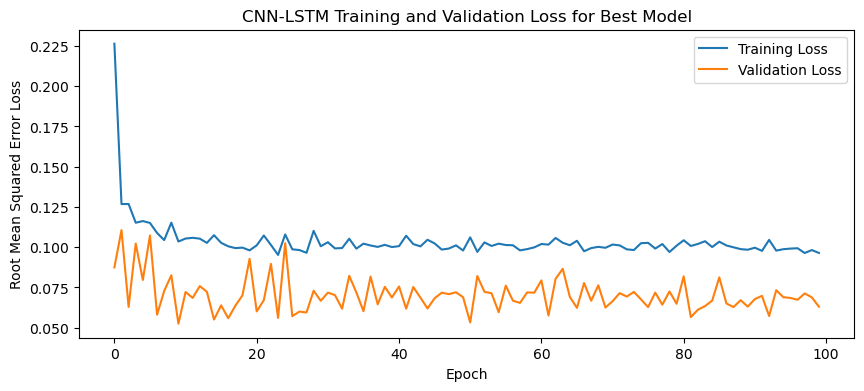

1/1 - 5s - loss: 0.1392 - 5s/epoch - 5s/step
Test Loss: 0.13922831416130066
Fold 2:
Epoch 1/100
19/19 [==============================] - 24s 372ms/step - loss: 0.2876 - val_loss: 0.1663
Epoch 2/100
19/19 [==============================] - 3s 133ms/step - loss: 0.1662 - val_loss: 0.1423
Epoch 3/100
19/19 [==============================] - 2s 131ms/step - loss: 0.1097 - val_loss: 0.0813
Epoch 4/100
19/19 [==============================] - 3s 135ms/step - loss: 0.1266 - val_loss: 0.0815
Epoch 5/100
19/19 [==============================] - 3s 141ms/step - loss: 0.1072 - val_loss: 0.0722
Epoch 6/100
19/19 [==============================] - 2s 120ms/step - loss: 0.1039 - val_loss: 0.0727
Epoch 7/100
19/19 [==============================] - 3s 146ms/step - loss: 0.1010 - val_loss: 0.0688
Epoch 8/100
19/19 [==============================] - 2s 127ms/step - loss: 0.0991 - val_loss: 0.0632
Epoch 9/100
19/19 [==============================] - 3s 142ms/step - loss: 0.0944 - val_loss: 0.0947
Epoch 

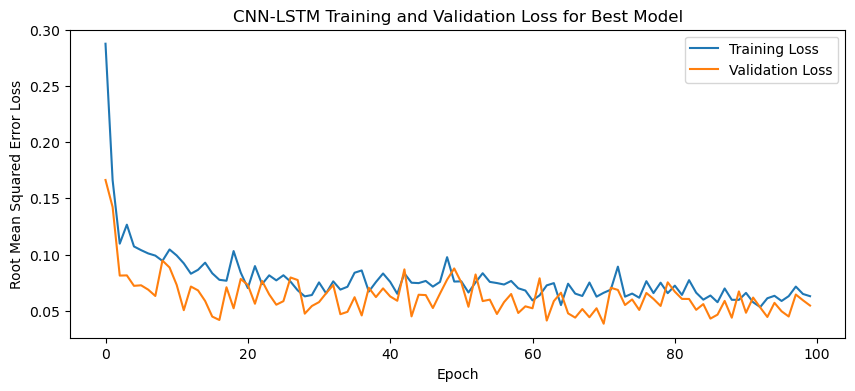

1/1 - 3s - loss: 0.0814 - 3s/epoch - 3s/step
Test Loss: 0.0814070850610733
Fold 3:
Epoch 1/100
19/19 [==============================] - 23s 250ms/step - loss: 0.2143 - val_loss: 0.1153
Epoch 2/100
19/19 [==============================] - 3s 167ms/step - loss: 0.1419 - val_loss: 0.0715
Epoch 3/100
19/19 [==============================] - 2s 105ms/step - loss: 0.1021 - val_loss: 0.0692
Epoch 4/100
19/19 [==============================] - 1s 67ms/step - loss: 0.1127 - val_loss: 0.0968
Epoch 5/100
19/19 [==============================] - 1s 70ms/step - loss: 0.1319 - val_loss: 0.0693
Epoch 6/100
19/19 [==============================] - 2s 91ms/step - loss: 0.1066 - val_loss: 0.0932
Epoch 7/100
19/19 [==============================] - 1s 64ms/step - loss: 0.1099 - val_loss: 0.0810
Epoch 8/100
19/19 [==============================] - 1s 56ms/step - loss: 0.1086 - val_loss: 0.1019
Epoch 9/100
19/19 [==============================] - 1s 54ms/step - loss: 0.0969 - val_loss: 0.0597
Epoch 10/100


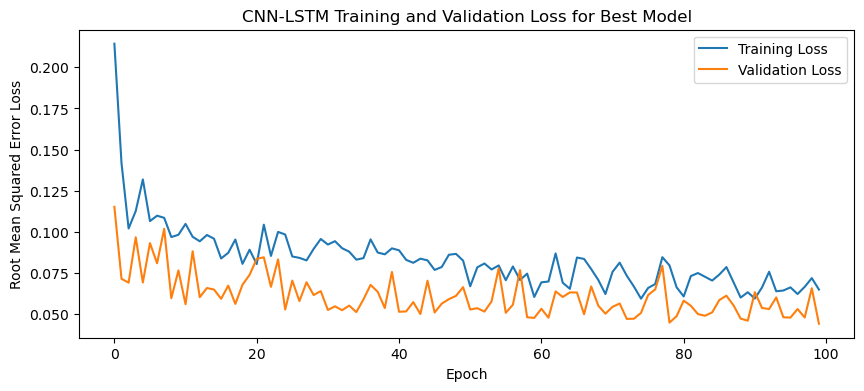

1/1 - 5s - loss: 0.0522 - 5s/epoch - 5s/step
Test Loss: 0.052205465734004974
Fold 4:
Epoch 1/100
20/20 [==============================] - 26s 310ms/step - loss: 0.3328 - val_loss: 0.1978
Epoch 2/100
20/20 [==============================] - 2s 107ms/step - loss: 0.1309 - val_loss: 0.1197
Epoch 3/100
20/20 [==============================] - 2s 105ms/step - loss: 0.1168 - val_loss: 0.1753
Epoch 4/100
20/20 [==============================] - 2s 116ms/step - loss: 0.1177 - val_loss: 0.1197
Epoch 5/100
20/20 [==============================] - 2s 108ms/step - loss: 0.1185 - val_loss: 0.1385
Epoch 6/100
20/20 [==============================] - 3s 133ms/step - loss: 0.1127 - val_loss: 0.0952
Epoch 7/100
20/20 [==============================] - 2s 119ms/step - loss: 0.1014 - val_loss: 0.1921
Epoch 8/100
20/20 [==============================] - 2s 118ms/step - loss: 0.1000 - val_loss: 0.1355
Epoch 9/100
20/20 [==============================] - 2s 121ms/step - loss: 0.0950 - val_loss: 0.1625
Epoch

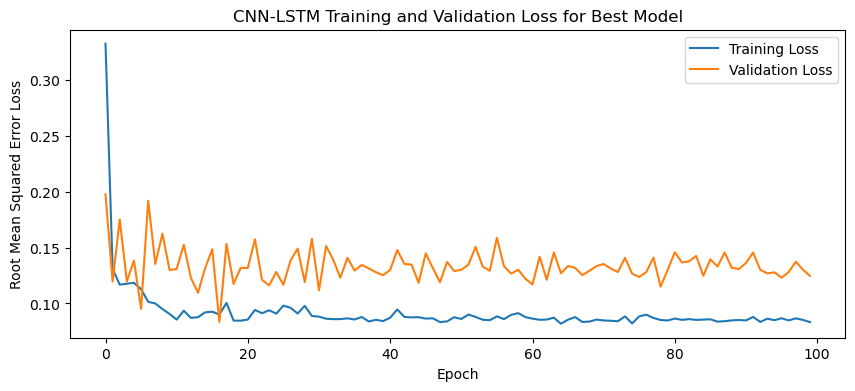

1/1 - 5s - loss: 0.0848 - 5s/epoch - 5s/step
Test Loss: 0.08477626740932465
Fold 5:
Epoch 1/100
19/19 [==============================] - 21s 363ms/step - loss: 0.2237 - val_loss: 0.2327
Epoch 2/100
19/19 [==============================] - 1s 68ms/step - loss: 0.1473 - val_loss: 0.1428
Epoch 3/100
19/19 [==============================] - 1s 69ms/step - loss: 0.1040 - val_loss: 0.1656
Epoch 4/100
19/19 [==============================] - 2s 90ms/step - loss: 0.1181 - val_loss: 0.1652
Epoch 5/100
19/19 [==============================] - 2s 85ms/step - loss: 0.1030 - val_loss: 0.1658
Epoch 6/100
19/19 [==============================] - 2s 84ms/step - loss: 0.1013 - val_loss: 0.1537
Epoch 7/100
19/19 [==============================] - 2s 93ms/step - loss: 0.0898 - val_loss: 0.1254
Epoch 8/100
19/19 [==============================] - 2s 94ms/step - loss: 0.0944 - val_loss: 0.1983
Epoch 9/100
19/19 [==============================] - 2s 89ms/step - loss: 0.0942 - val_loss: 0.1123
Epoch 10/100
1

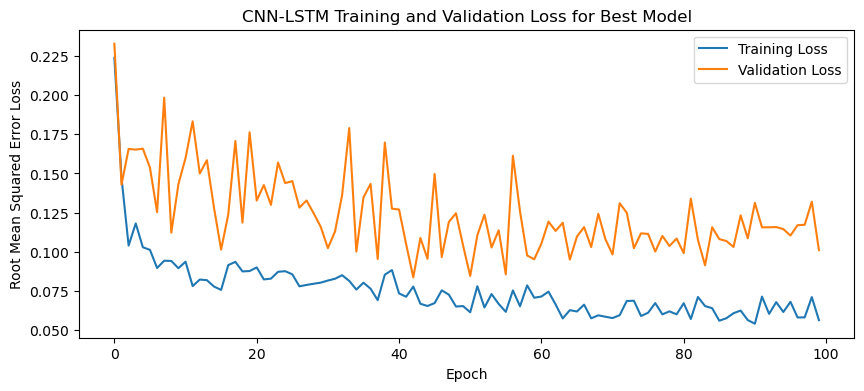

1/1 - 4s - loss: 0.0727 - 4s/epoch - 4s/step
Test Loss: 0.07265844196081161


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

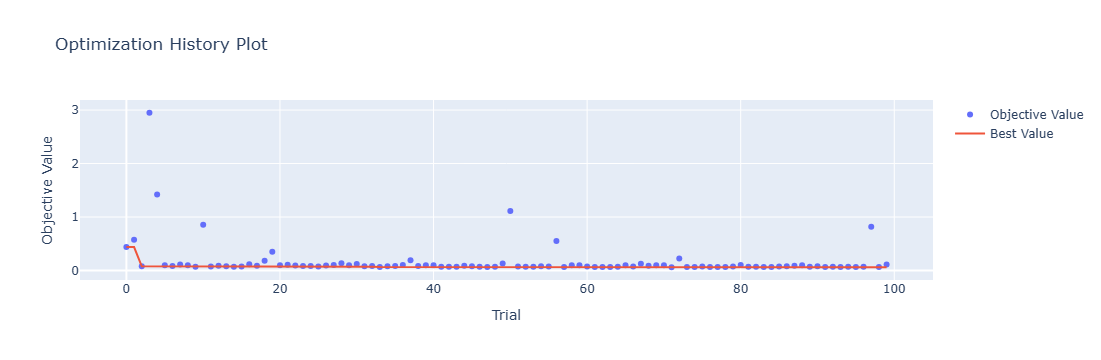

In [4]:
optuna.visualization.plot_optimization_history(study)

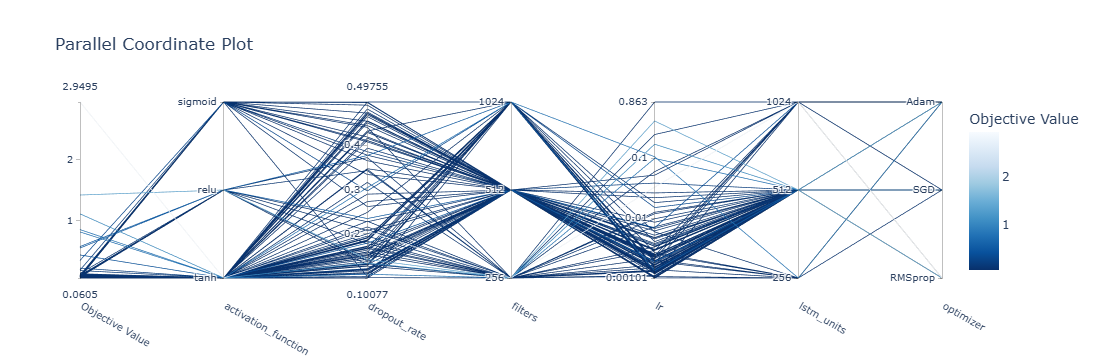

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

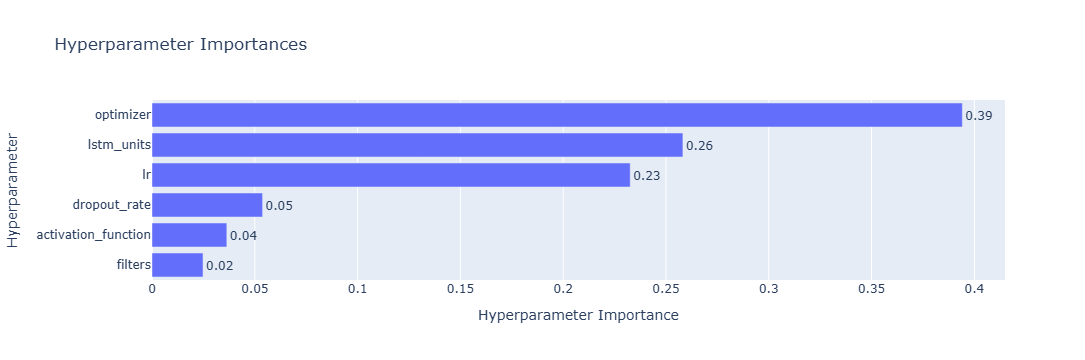

In [6]:
optuna.visualization.plot_param_importances(study)

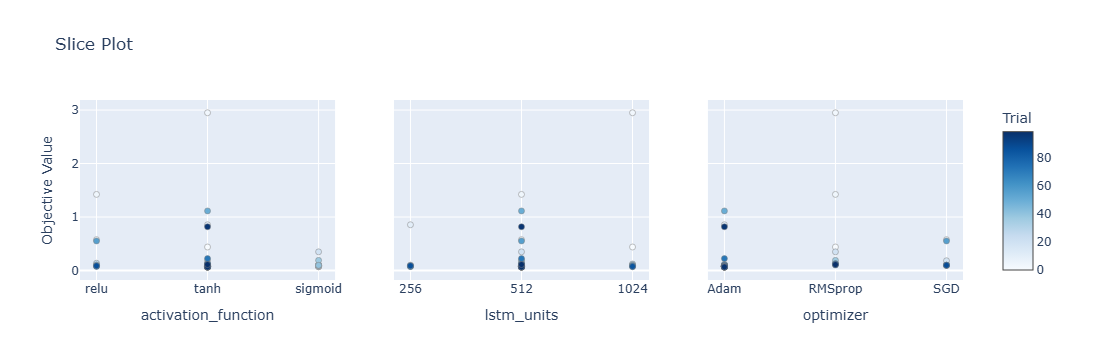

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

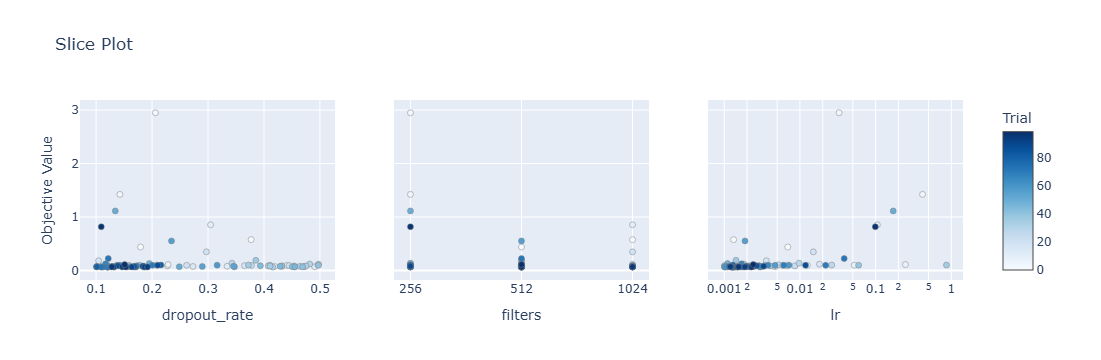

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 6s 90ms/step - loss: 0.2575 - accuracy: 0.3684 - mae: 0.2274 - rmse: 0.2575 - mape: 39.5303 - pearson: 0.2874 - val_loss: 0.1083 - val_accuracy: 0.6667 - val_mae: 0.0900 - val_rmse: 0.1083 - val_mape: 17.7073 - val_pearson: 0.5831
Epoch 2/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1484 - accuracy: 0.4211 - mae: 0.1225 - rmse: 0.1484 - mape: 23.1212 - pearson: 0.3017 - val_loss: 0.1575 - val_accuracy: 0.6667 - val_mae: 0.1342 - val_rmse: 0.1575 - val_mape: 23.3681 - val_pearson: 0.8381
Epoch 3/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1335 - accuracy: 

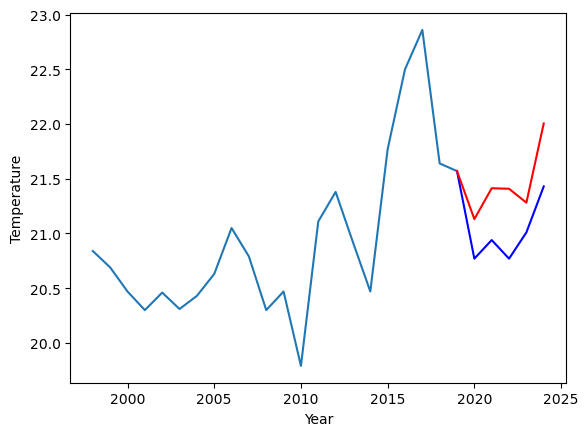

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
17.52		16.87		-0.65
16.69		17.14		0.45
16.18		17.14		0.96
16.46		17.01		0.55
16.29		17.74		1.45


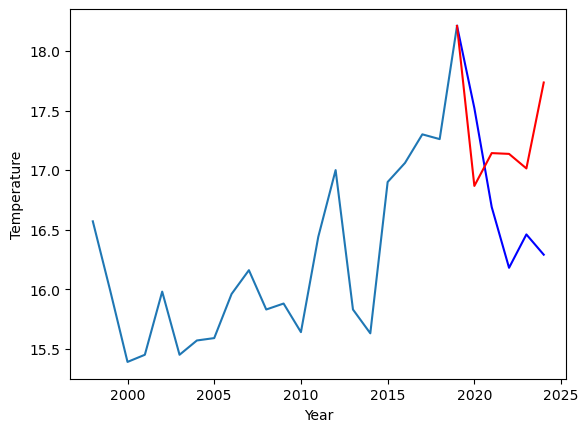

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.77  21.131527
1                1   17.52  16.867134


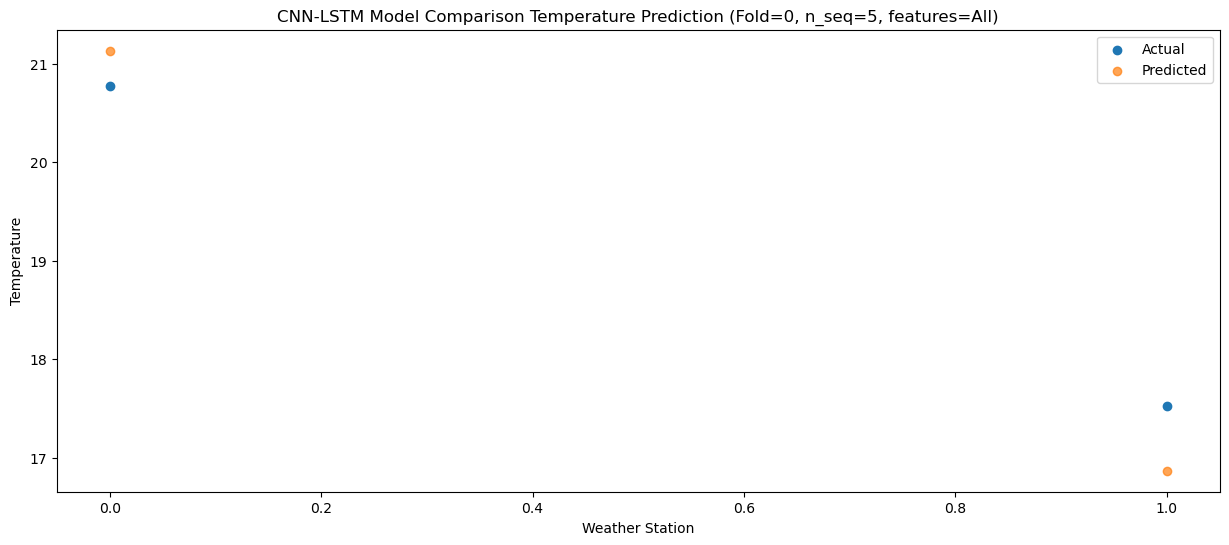

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.94  21.413429
1                1   16.69  17.142575


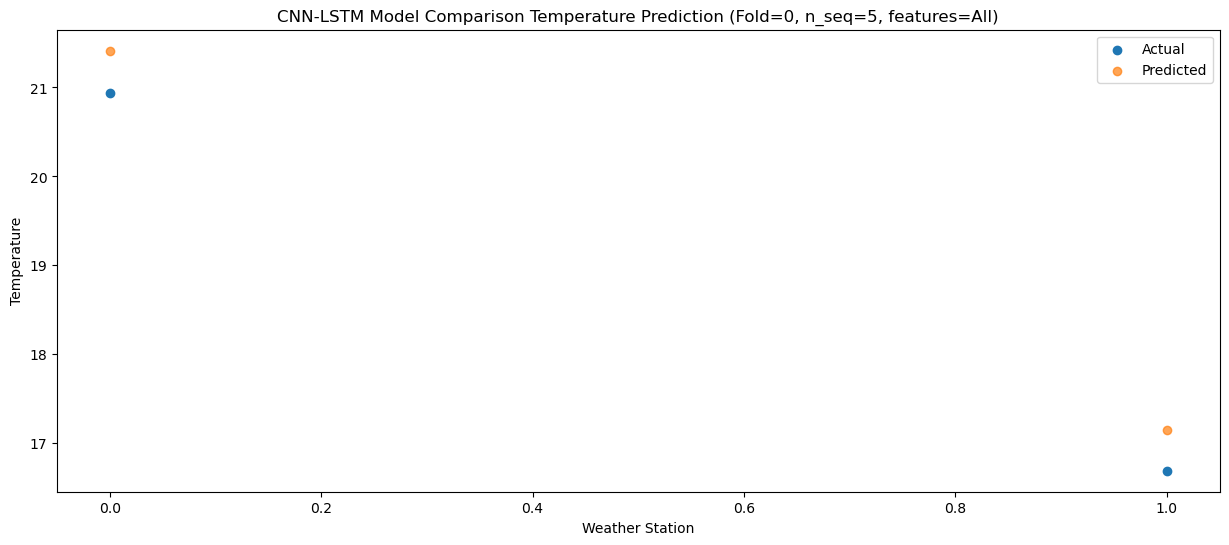

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.77  21.408778
1                1   16.18  17.136024


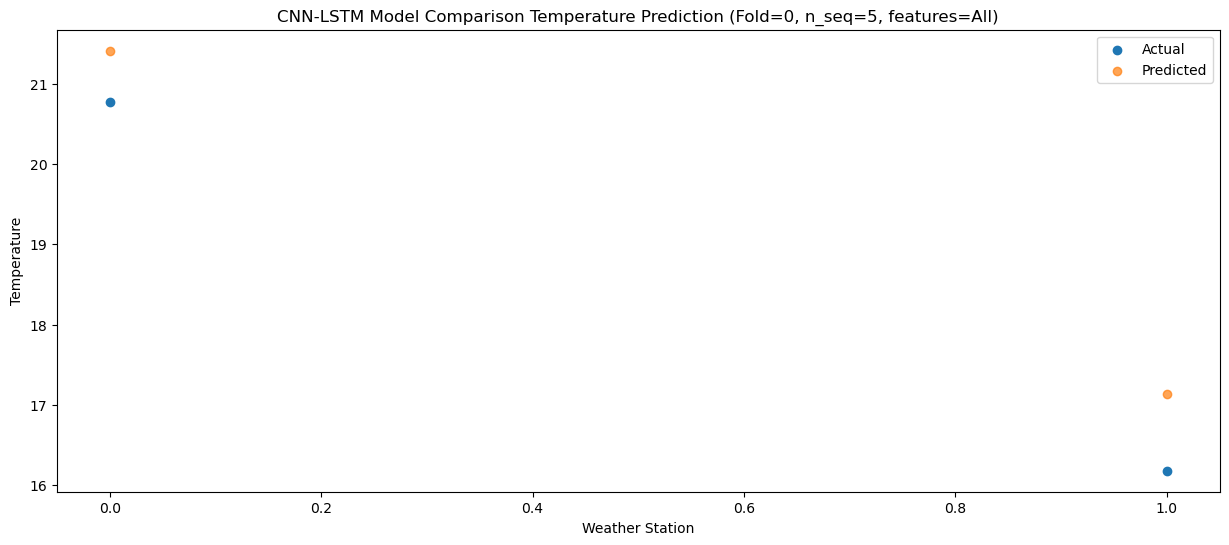

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.01  21.281845
1                1   16.46  17.013903


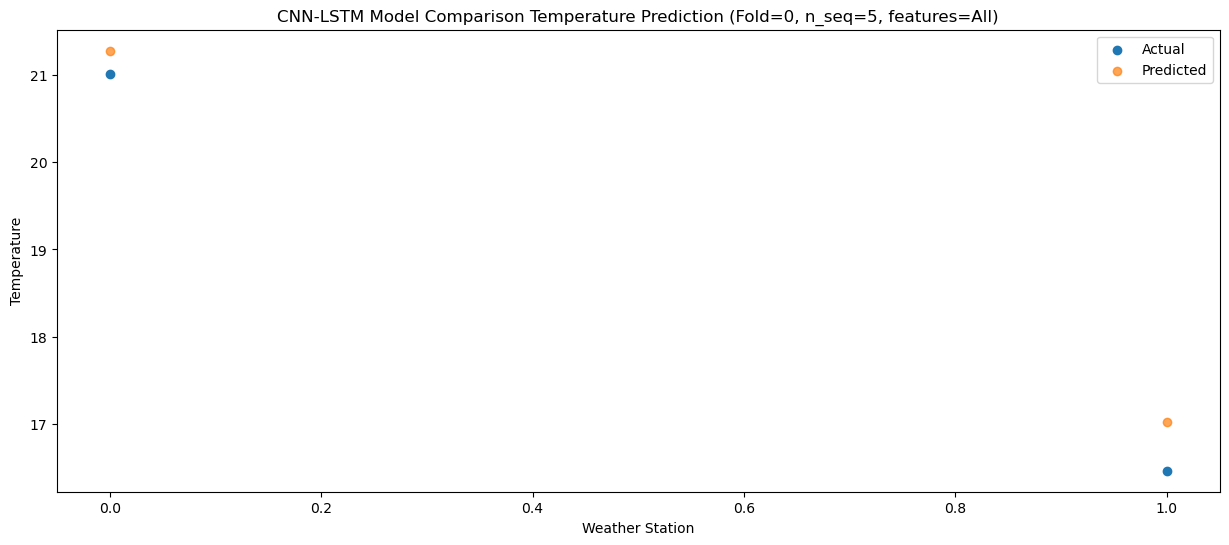

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.43  22.005041
1                1   16.29  17.735186


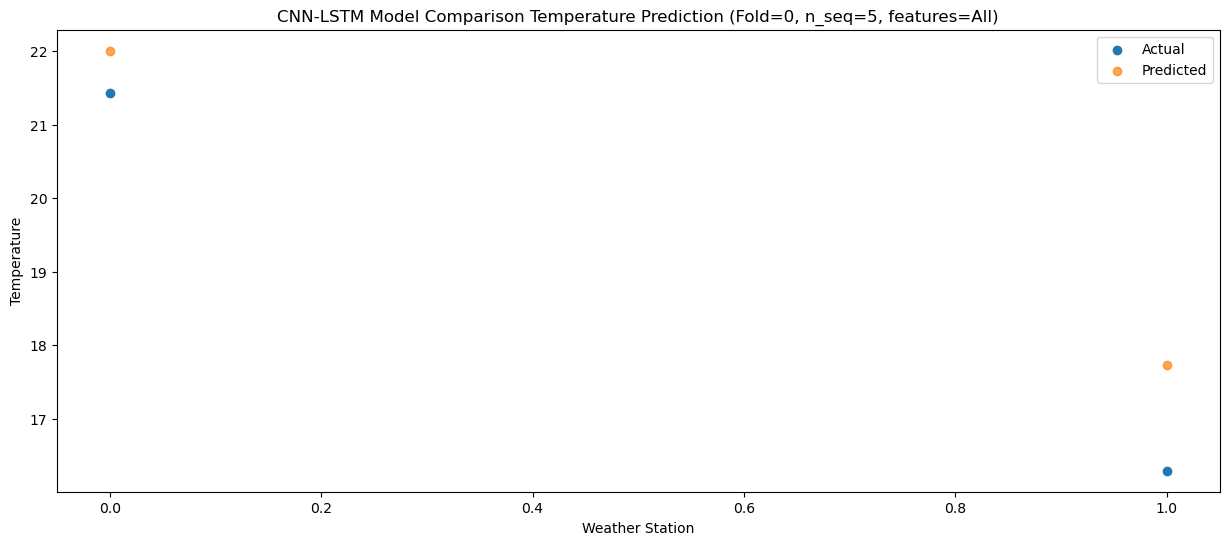

f, t:
[[20.77 17.52]
 [20.94 16.69]
 [20.77 16.18]
 [21.01 16.46]
 [21.43 16.29]]
[[21.13152748 16.86713377]
 [21.41342878 17.14257479]
 [21.4087779  17.13602377]
 [21.28184497 17.01390265]
 [22.00504052 17.73518561]]
Year at t+1:
t+1 SKRMSE: 0.527701
t+1 KRMSE: 0.527701
t+1 MAE: 0.507197
t+1 SKMAPE: 0.027335
t+1 R2_SCORE: 0.894545
t+1 KMAPE: 0.027335
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.463119
t+2 KRMSE: 0.463119
t+2 MAE: 0.463002
t+2 SKMAPE: 0.024863
t+2 R2_SCORE: 0.952503
t+2 KMAPE: 0.024863
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.813025
t+3 KRMSE: 0.813025
t+3 MAE: 0.797401
t+3 SKMAPE: 0.044921
t+3 R2_SCORE: 0.874500
t+3 KMAPE: 0.044921
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.436296
t+4 KRMSE: 0.436296
t+4 MAE: 0.412874
t+4 SKMAPE: 0.023295
t+4 R2_SCORE: 0.963221
t+4 KMAPE: 0.023295
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 1.099826
t+5 KRMSE: 1.099826
t+5 MAE: 1.010113
t+5 SKMAPE: 0.057775
t+5 R2_SCORE: 0.816861
t+5 KMAPE: 0.057775
t+5 PEARSON: 1

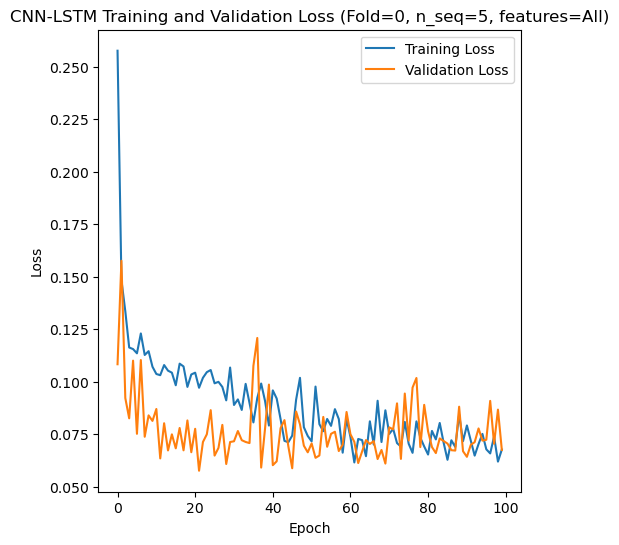

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 6s 109ms/step - loss: 0.2946 - accuracy: 0.3684 - mae: 0.2628 - rmse: 0.2946 - mape: 42.6237 - pearson: 0.4203 - val_loss: 0.0985 - val_accuracy: 1.0000 - val_mae: 0.0871 - val_rmse: 0.0985 - val_mape: 13.9164 - val_pearson: 0.4572
Epoch 2/100
19/19 [==============================] - 0s 21ms/step - loss: 0.1590 - accuracy: 0.3158 - mae: 0.1394 - rmse: 0.1590 - mape: 22.4478 - pearson: 0.3557 - val_loss: 0.1271 - val_accuracy: 0.0000e+00 - val_mae: 0.1000 - val_rmse: 0.1271 - val_mape: 16.4321 - val_pearson: 0.2289
Epoch 3/100
19/19 [==============================] - 0s 25ms/step - loss: 0.1215 - accura

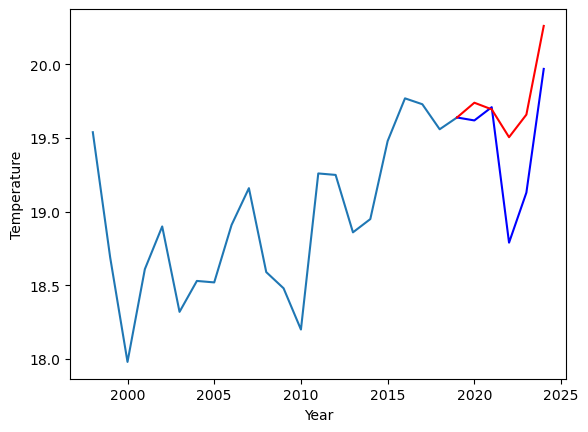

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.82		19.42		-0.40
20.34		19.96		-0.38
19.95		19.91		-0.04
19.95		19.54		-0.41
21.26		20.34		-0.92


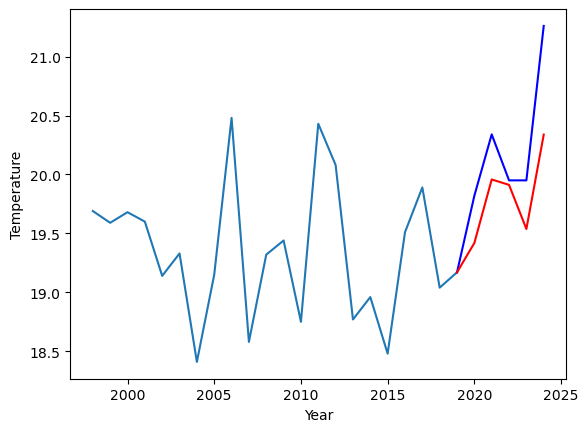

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.62  19.740286
1                1   19.82  19.418946


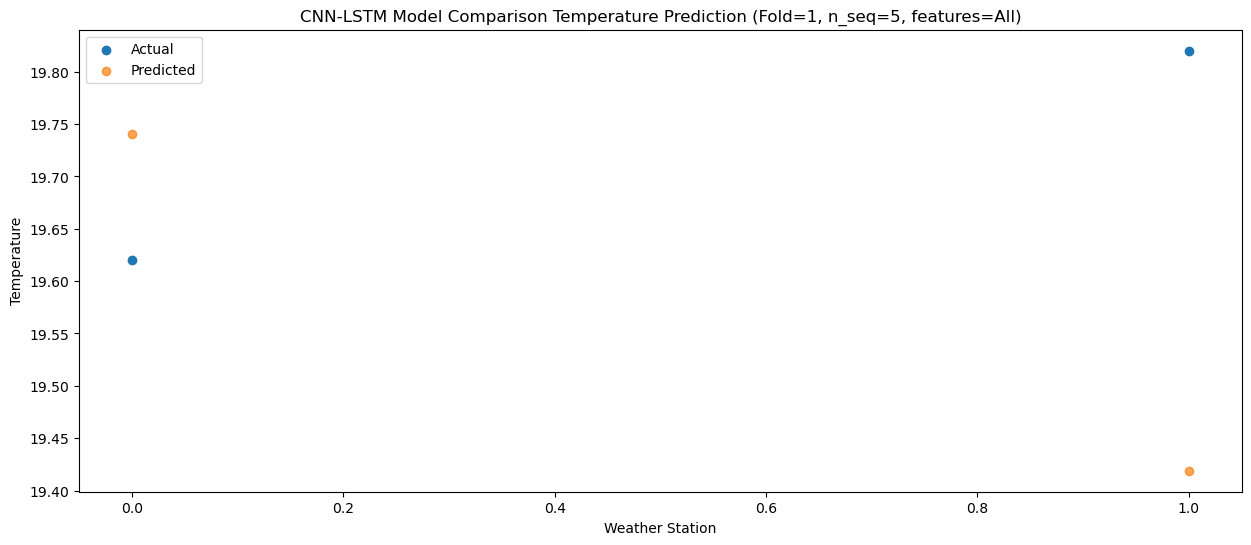

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   19.71  19.695262
1                1   20.34  19.957660


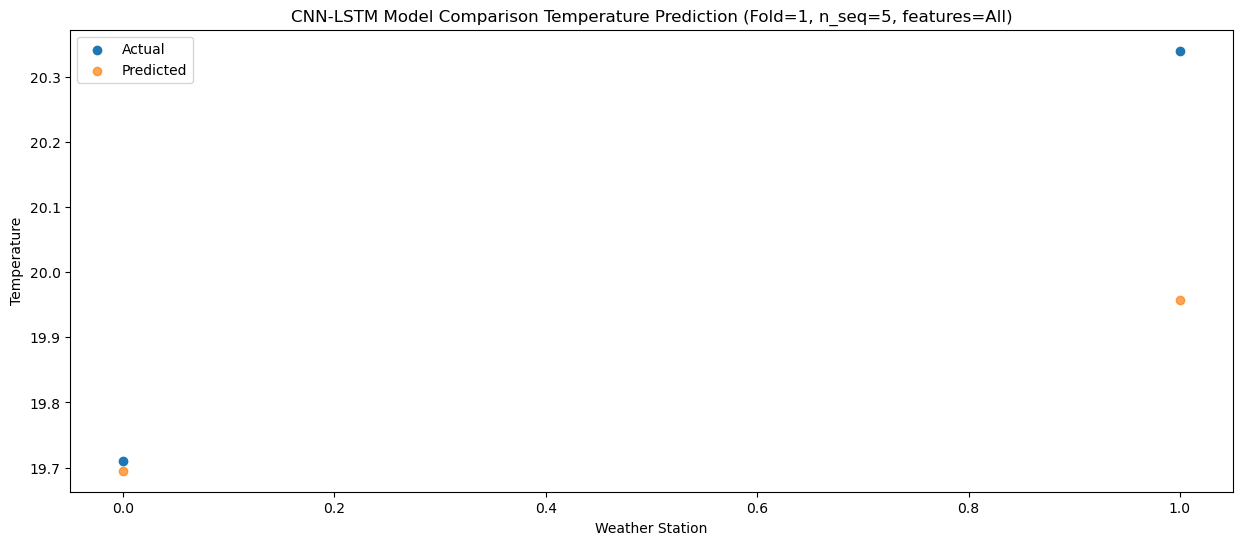

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.79  19.506160
1                1   19.95  19.911698


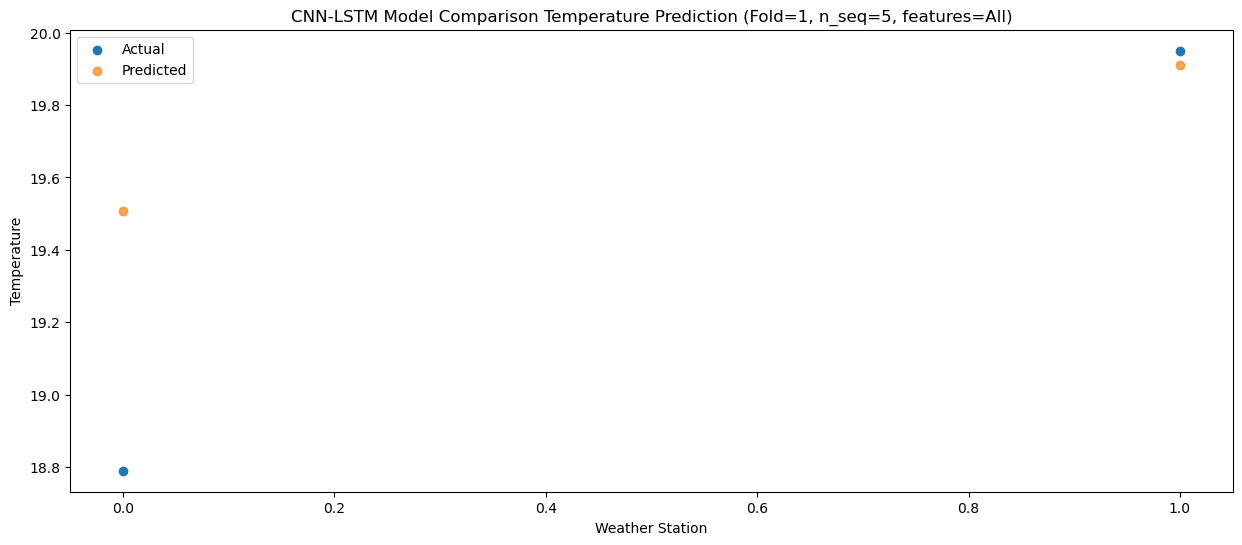

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   19.13  19.659509
1                1   19.95  19.537615


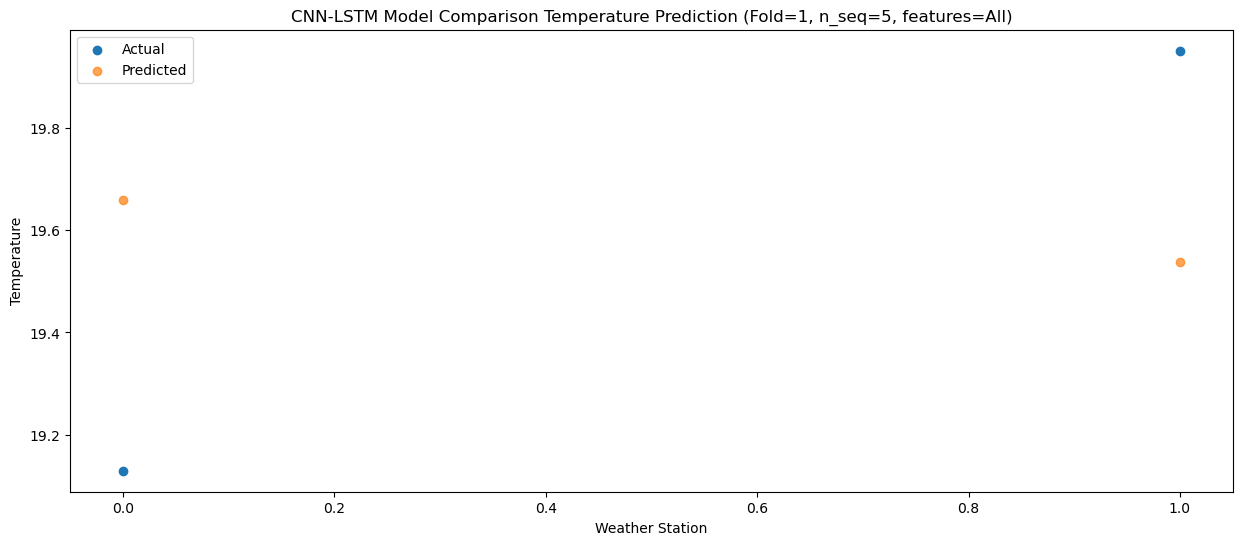

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   19.97   20.26184
1                1   21.26   20.33809


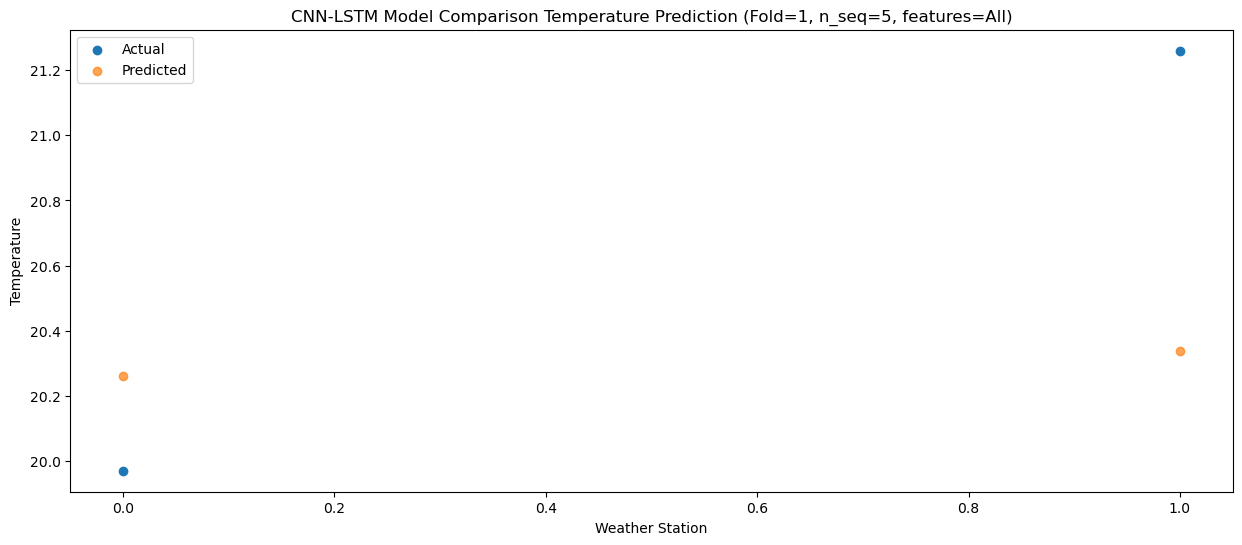

f, t:
[[19.62 19.82]
 [19.71 20.34]
 [18.79 19.95]
 [19.13 19.95]
 [19.97 21.26]]
[[19.74028618 19.41894585]
 [19.69526234 19.9576605 ]
 [19.50615975 19.91169797]
 [19.65950928 19.53761532]
 [20.26184032 20.33808979]]
Year at t+1:
t+1 SKRMSE: 0.296069
t+1 KRMSE: 0.296069
t+1 MAE: 0.260670
t+1 SKMAPE: 0.013183
t+1 R2_SCORE: -7.765660
t+1 KMAPE: 0.013183
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.270556
t+2 KRMSE: 0.270556
t+2 MAE: 0.198539
t+2 SKMAPE: 0.009773
t+2 R2_SCORE: 0.262279
t+2 KMAPE: 0.009773
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.507125
t+3 KRMSE: 0.507125
t+3 MAE: 0.377231
t+3 SKMAPE: 0.020017
t+3 R2_SCORE: 0.235506
t+3 KMAPE: 0.020017
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.474574
t+4 KRMSE: 0.474574
t+4 MAE: 0.470947
t+4 SKMAPE: 0.024175
t+4 R2_SCORE: -0.339801
t+4 KMAPE: 0.024175
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.683772
t+5 KRMSE: 0.683772
t+5 MAE: 0.606875
t+5 SKMAPE: 0.028989
t+5 R2_SCORE: -0.123838
t+5 KMAPE: 0.028989
t+5 PEARSON

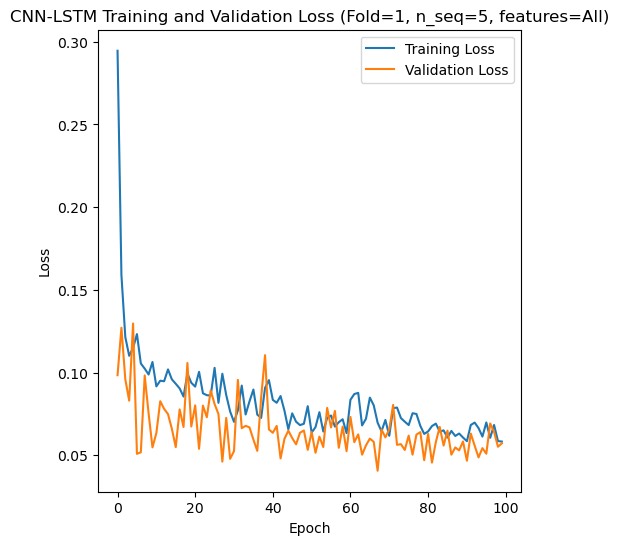

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 6s 86ms/step - loss: 0.2127 - accuracy: 0.2632 - mae: 0.1858 - rmse: 0.2127 - mape: 29.3550 - pearson: 0.3790 - val_loss: 0.1643 - val_accuracy: 0.0000e+00 - val_mae: 0.1493 - val_rmse: 0.1643 - val_mape: 23.6410 - val_pearson: 0.3789
Epoch 2/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1667 - accuracy: 0.3684 - mae: 0.1437 - rmse: 0.1667 - mape: 23.2316 - pearson: 0.4968 - val_loss: 0.1185 - val_accuracy: 0.3333 - val_mae: 0.1031 - val_rmse: 0.1185 - val_mape: 15.2885 - val_pearson: 0.4090
Epoch 3/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1243 - accurac

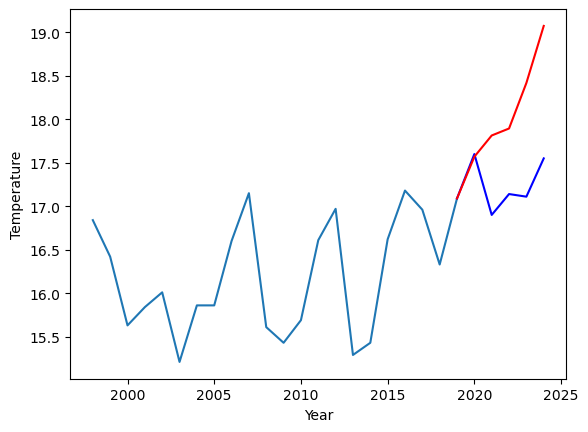

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.84		13.91		0.07
13.83		14.57		0.74
13.82		14.85		1.03
13.36		14.92		1.56
14.15		15.76		1.61


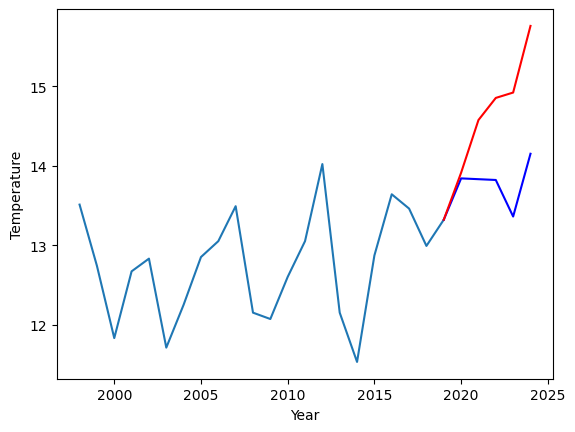

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   17.60  17.569378
1                1   13.84  13.911291


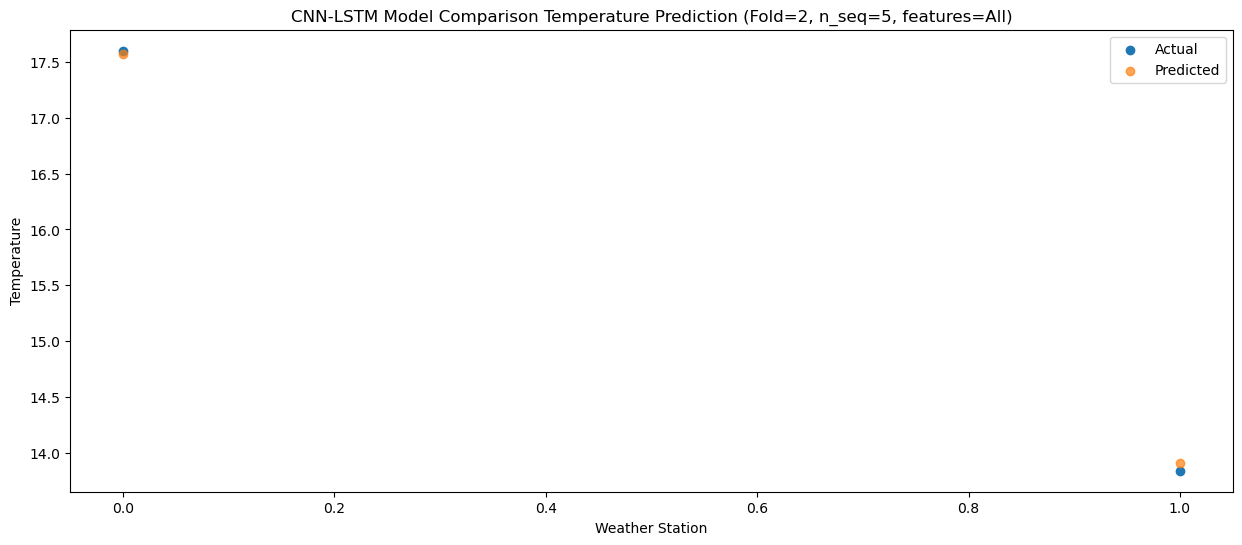

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   16.90  17.813345
1                1   13.83  14.574353


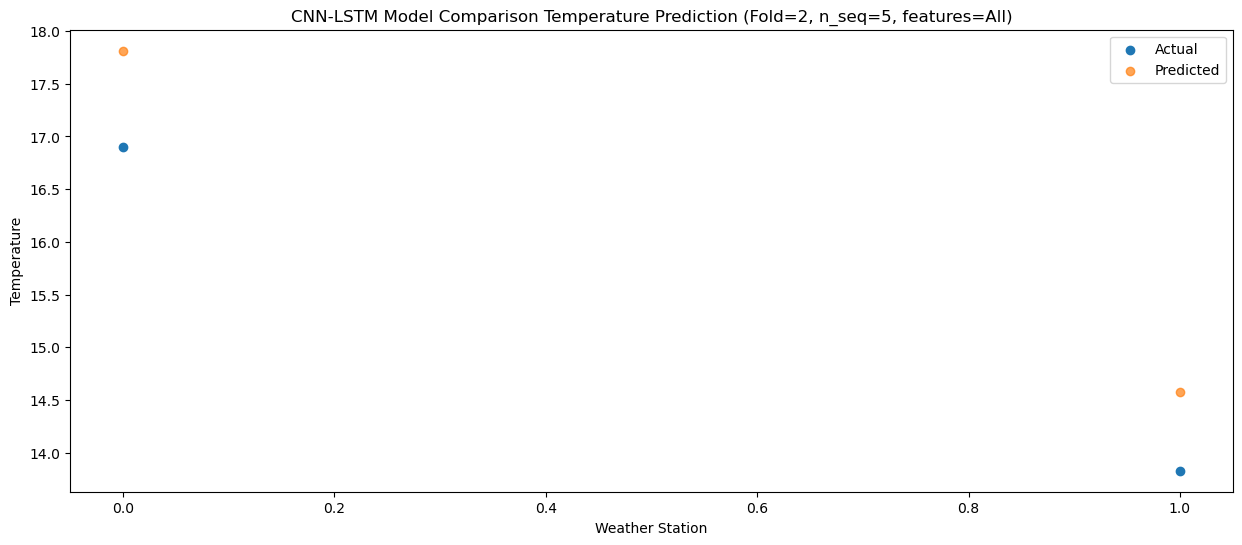

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   17.14  17.893701
1                1   13.82  14.852863


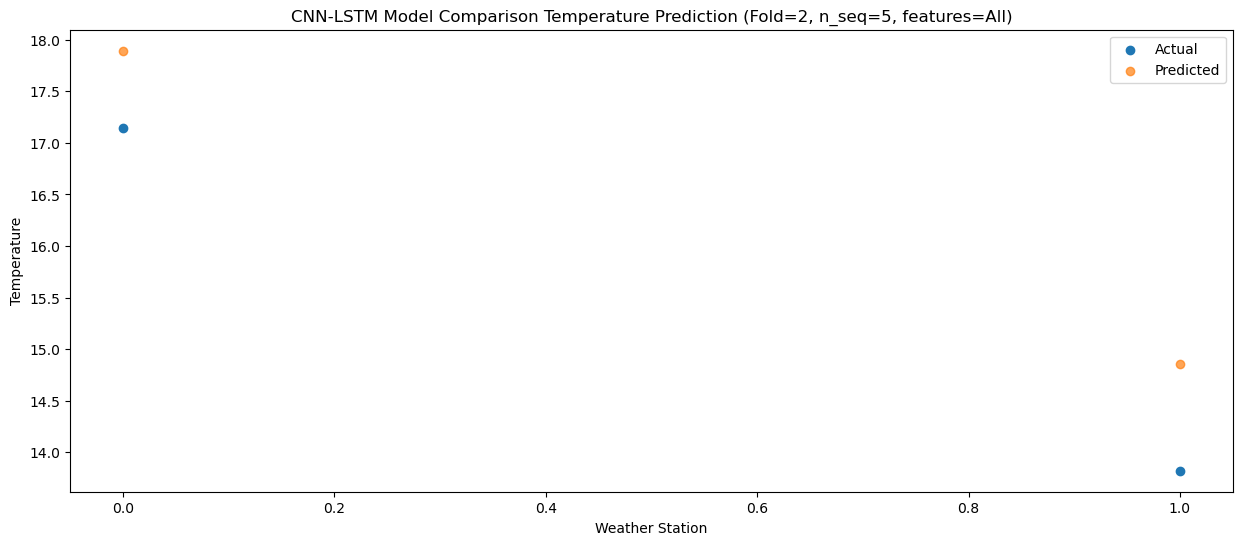

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   17.11  18.417410
1                1   13.36  14.920418


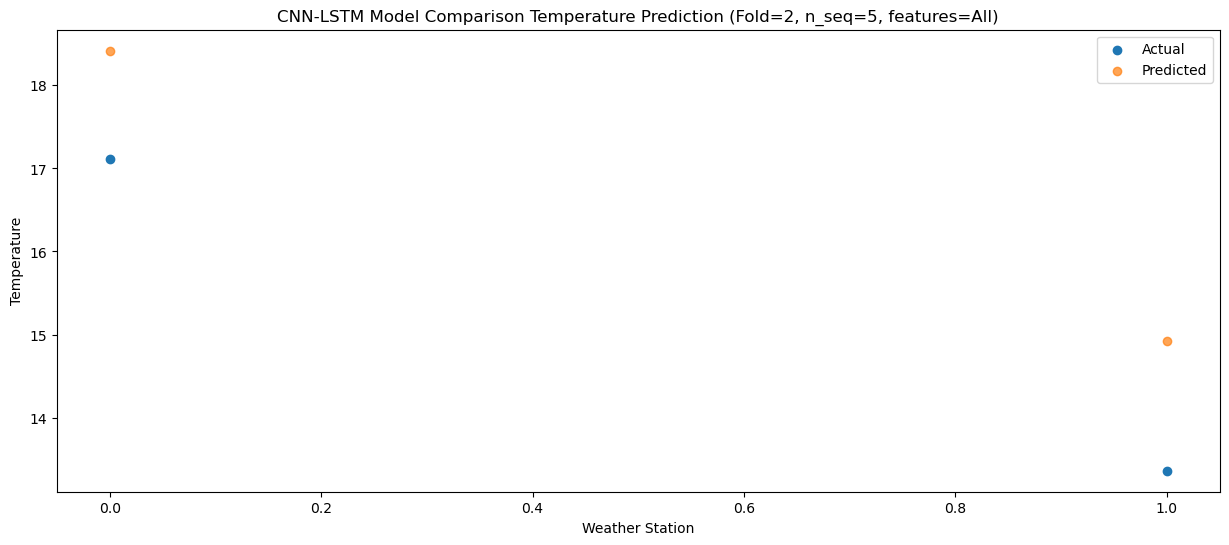

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.55  19.073008
1                1   14.15  15.759009


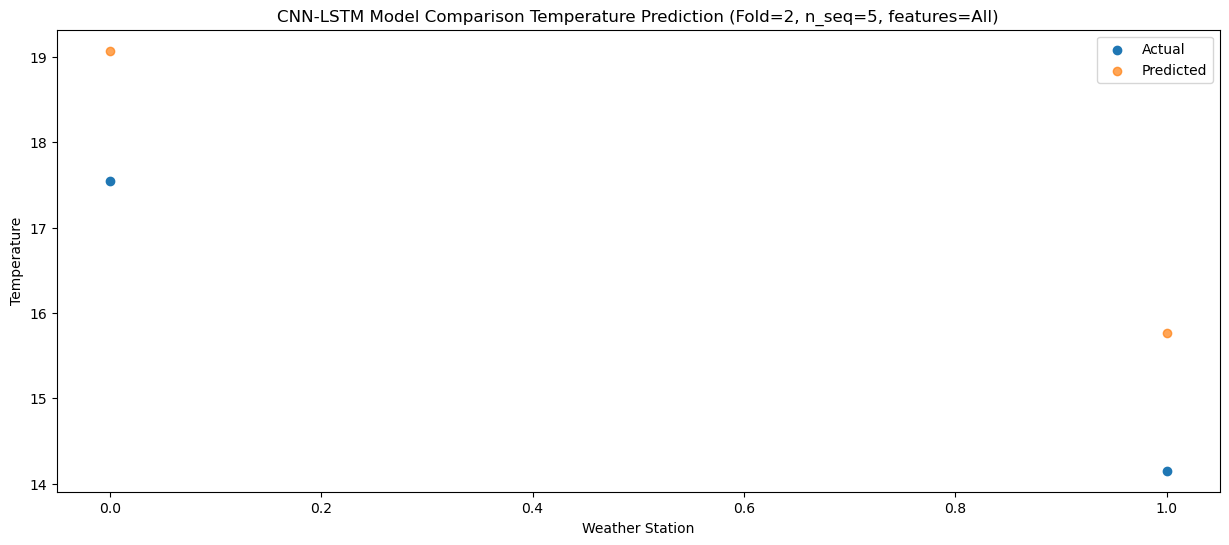

f, t:
[[17.6  13.84]
 [16.9  13.83]
 [17.14 13.82]
 [17.11 13.36]
 [17.55 14.15]]
[[17.56937799 13.91129095]
 [17.81334541 14.57435311]
 [17.89370095 14.85286338]
 [18.41740965 14.92041766]
 [19.07300763 15.75900882]]
Year at t+1:
t+1 SKRMSE: 0.054864
t+1 KRMSE: 0.054864
t+1 MAE: 0.050956
t+1 SKMAPE: 0.003445
t+1 R2_SCORE: 0.999148
t+1 KMAPE: 0.003445
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.833145
t+2 KRMSE: 0.833145
t+2 MAE: 0.828849
t+2 SKMAPE: 0.053933
t+2 R2_SCORE: 0.705406
t+2 KMAPE: 0.053933
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.904122
t+3 KRMSE: 0.904122
t+3 MAE: 0.893282
t+3 SKMAPE: 0.059355
t+3 R2_SCORE: 0.703355
t+3 KMAPE: 0.059355
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 1.439483
t+4 KRMSE: 1.439483
t+4 MAE: 1.433914
t+4 SKMAPE: 0.096605
t+4 R2_SCORE: 0.410599
t+4 KMAPE: 0.096605
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 1.566598
t+5 KRMSE: 1.566598
t+5 MAE: 1.566008
t+5 SKMAPE: 0.100246
t+5 R2_SCORE: 0.150785
t+5 KMAPE: 0.100246
t+5 PEARSON: 1

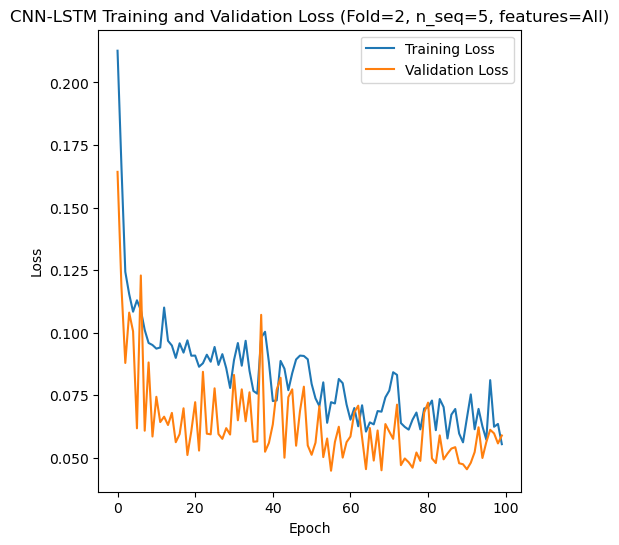

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 8s 154ms/step - loss: 0.2451 - accuracy: 0.1500 - mae: 0.2146 - rmse: 0.2451 - mape: 32.4992 - pearson: 0.1969 - val_loss: 0.1727 - val_accuracy: 0.5000 - val_mae: 0.1423 - val_rmse: 0.1727 - val_mape: 19.4670 - val_pearson: 0.6787
Epoch 2/100
20/20 [==============================] - 0s 24ms/step - loss: 0.1379 - accuracy: 0.4000 - mae: 0.1164 - rmse: 0.1379 - mape: 18.1093 - pearson: 0.3370 - val_loss: 0.1580 - val_accuracy: 0.5000 - val_mae: 0.1437 - val_rmse: 0.1580 - val_mape: 21.0572 - val_pearson: 0.5916
Epoch 3/100
20/20 [==============================] - 0s 21ms/step - loss: 0.1242 - accuracy: 0

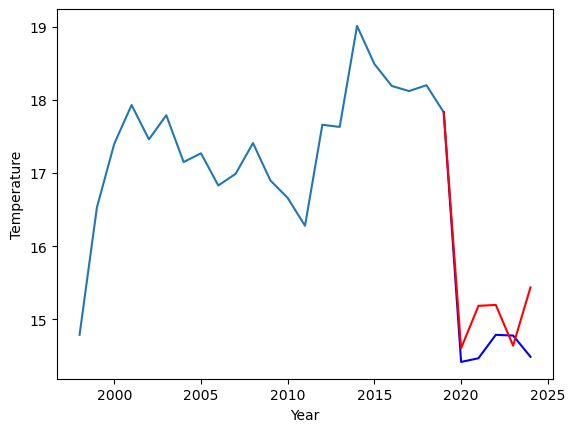

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.47		13.88		-0.59
14.35		14.46		0.11
14.15		14.47		0.32
13.85		13.91		0.06
14.87		14.71		-0.16


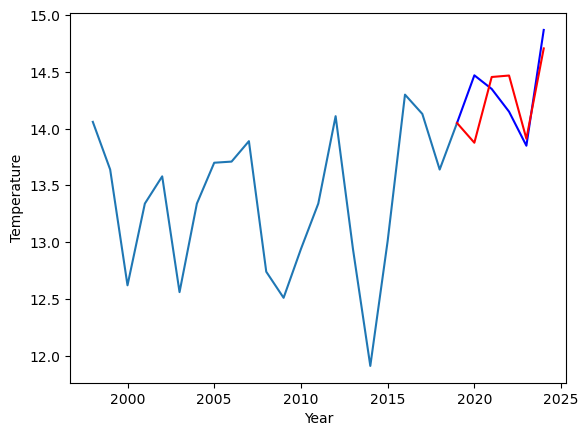

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   14.42  14.606040
1                1   14.47  13.876202


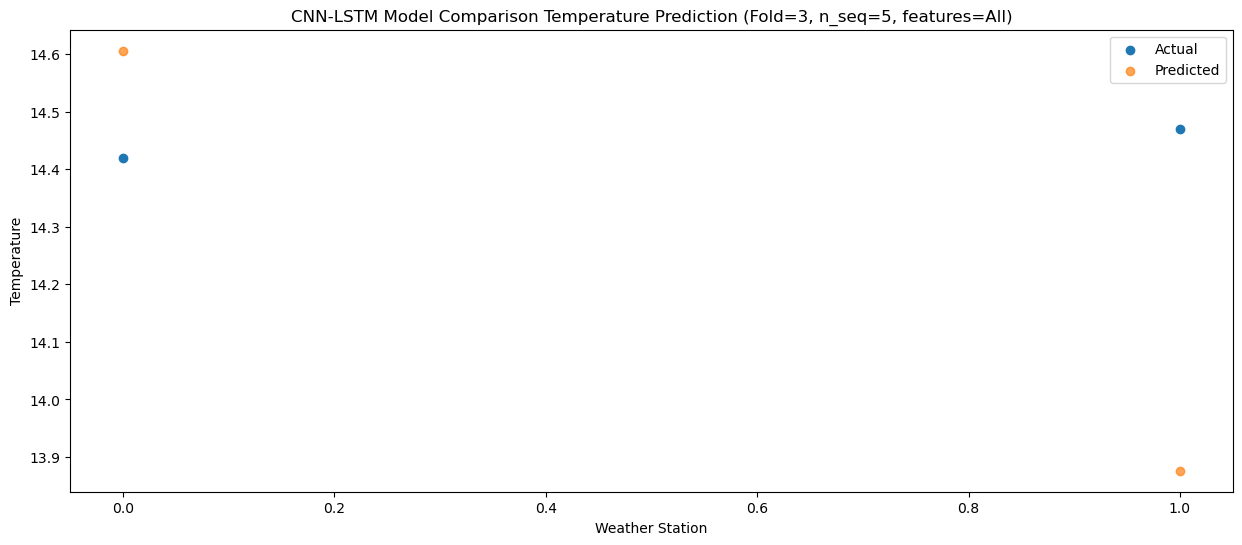

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   14.47  15.185699
1                1   14.35  14.455284


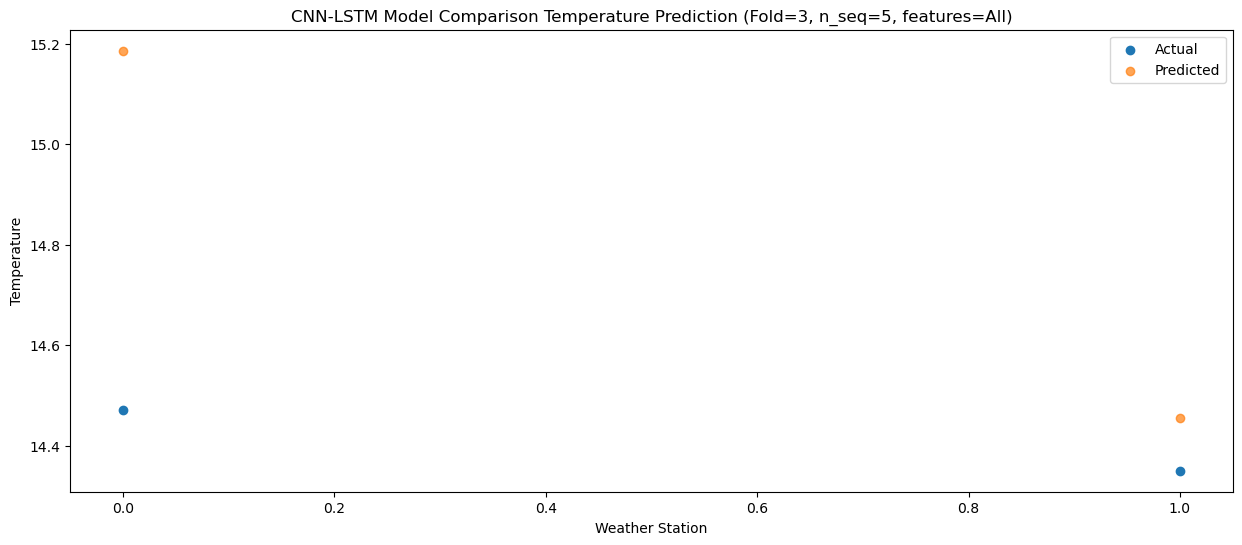

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   14.79  15.198700
1                1   14.15  14.468183


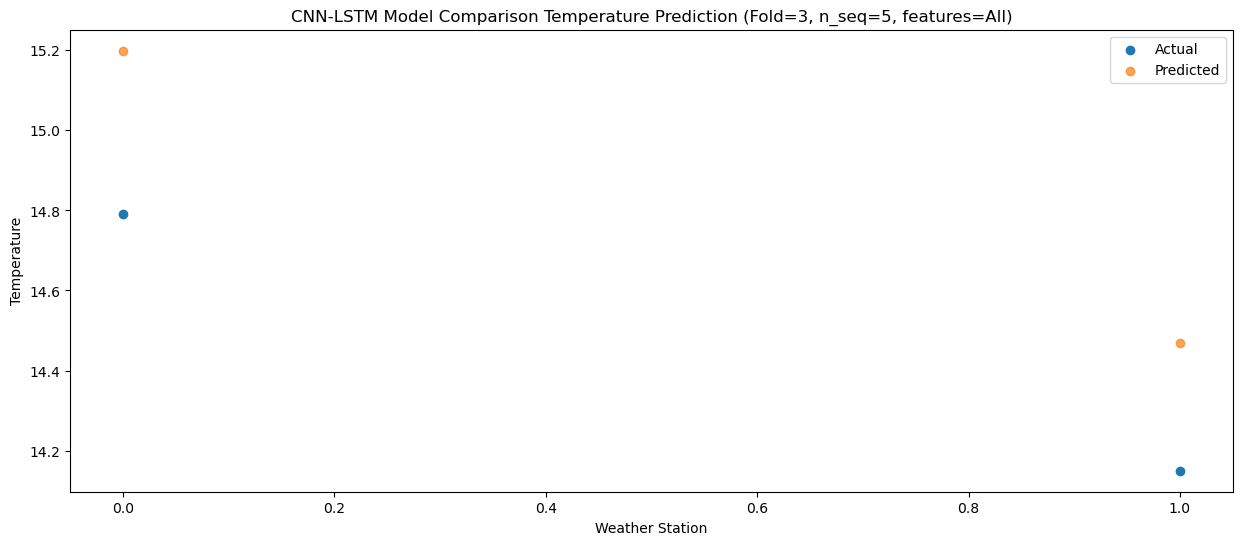

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.78  14.641676
1                1   13.85  13.911150


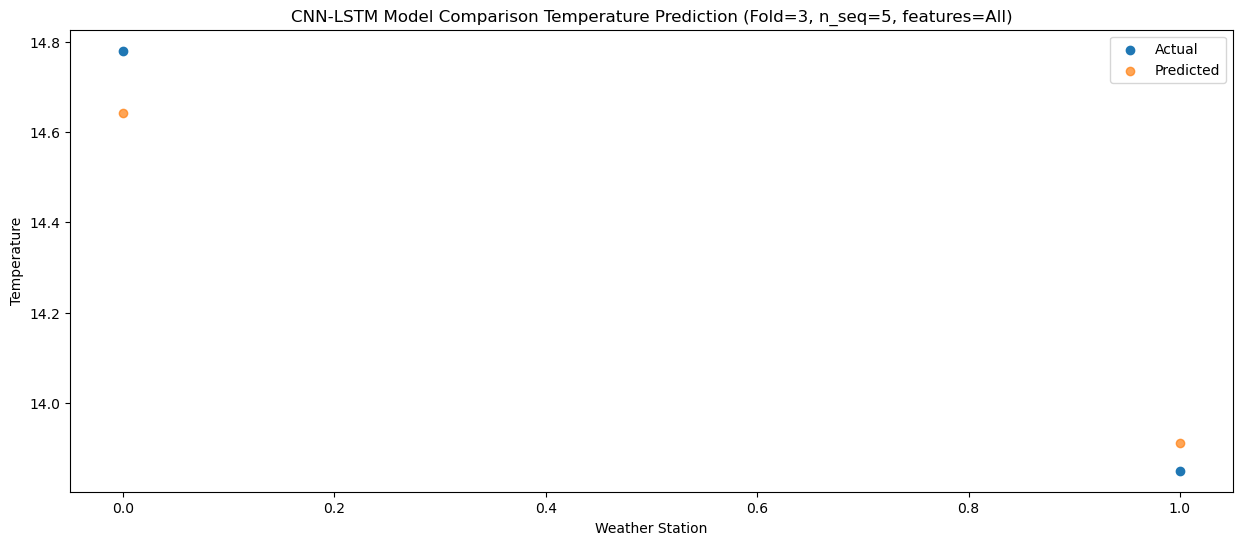

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   14.49  15.437780
1                1   14.87  14.707077


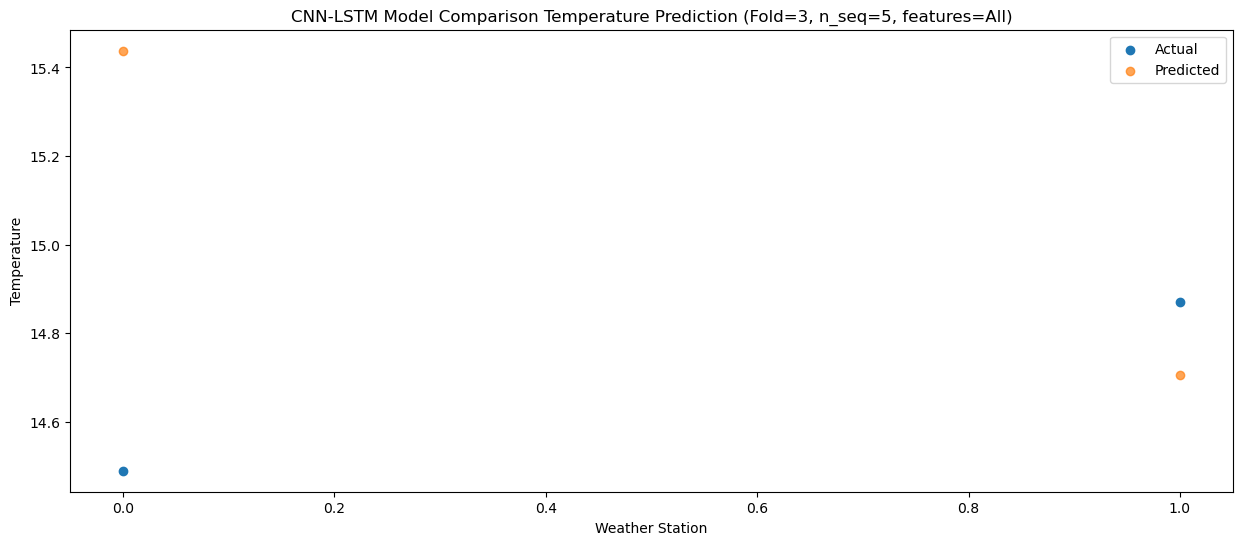

f, t:
[[14.42 14.47]
 [14.47 14.35]
 [14.79 14.15]
 [14.78 13.85]
 [14.49 14.87]]
[[14.60603992 13.87620245]
 [15.18569861 14.45528356]
 [15.19870049 14.46818331]
 [14.64167583 13.91115013]
 [15.43778027 14.70707742]]
Year at t+1:
t+1 SKRMSE: 0.440004
t+1 KRMSE: 0.440004
t+1 MAE: 0.389919
t+1 SKMAPE: 0.026969
t+1 R2_SCORE: -308.765109
t+1 KMAPE: 0.026969
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.511522
t+2 KRMSE: 0.511522
t+2 MAE: 0.410491
t+2 SKMAPE: 0.028399
t+2 R2_SCORE: -71.681823
t+2 KMAPE: 0.028399
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.366249
t+3 KRMSE: 0.366249
t+3 MAE: 0.363442
t+3 SKMAPE: 0.025060
t+3 R2_SCORE: -0.309945
t+3 KMAPE: 0.025060
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.106941
t+4 KRMSE: 0.106941
t+4 MAE: 0.099737
t+4 SKMAPE: 0.006887
t+4 R2_SCORE: 0.947109
t+4 KMAPE: 0.006887
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.680011
t+5 KRMSE: 0.680011
t+5 MAE: 0.555351
t+5 SKMAPE: 0.038183
t+5 R2_SCORE: -11.809296
t+5 KMAPE: 0.038183
t+5 PE

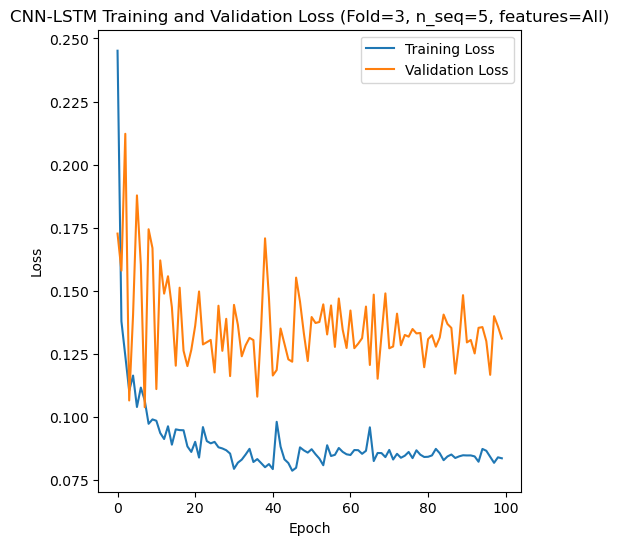

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 6s 122ms/step - loss: 0.2044 - accuracy: 0.2632 - mae: 0.1741 - rmse: 0.2044 - mape: 27.4570 - pearson: 0.4079 - val_loss: 0.1237 - val_accuracy: 1.0000 - val_mae: 0.0953 - val_rmse: 0.1237 - val_mape: 17.0970 - val_pearson: 0.5958
Epoch 2/100
19/19 [==============================] - 0s 21ms/step - loss: 0.1419 - accuracy: 0.2105 - mae: 0.1250 - rmse: 0.1419 - mape: 19.7770 - pearson: 0.3151 - val_loss: 0.1801 - val_accuracy: 1.0000 - val_mae: 0.1617 - val_rmse: 0.1801 - val_mape: 25.0832 - val_pearson: 0.3421
Epoch 3/100
19/19 [==============================] - 0s 21ms/step - loss: 0.1400 - accuracy:

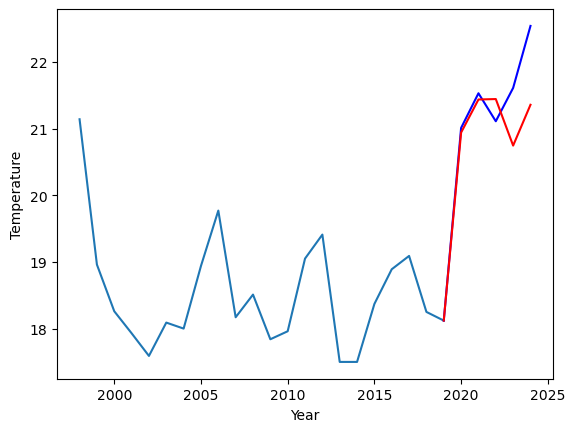

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.23		12.68		0.45
12.79		13.29		0.50
13.11		13.35		0.24
12.24		12.56		0.32
13.72		13.22		-0.50


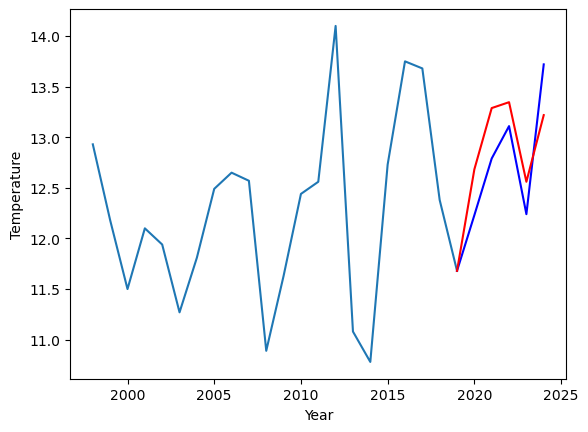

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.01  20.940652
1                1   12.23  12.682813


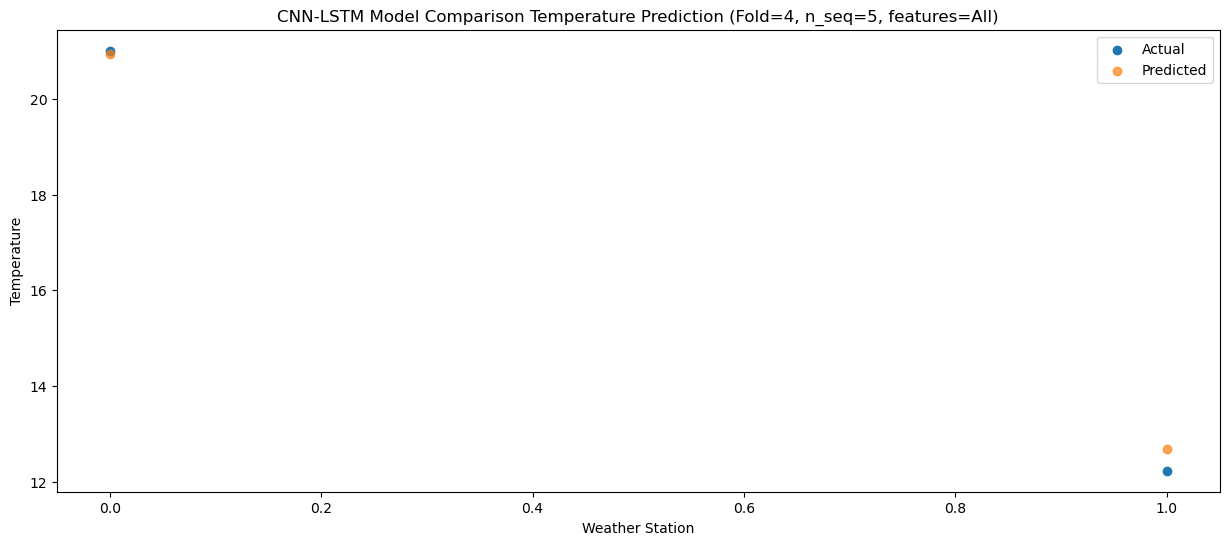

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.53  21.436369
1                1   12.79  13.288304


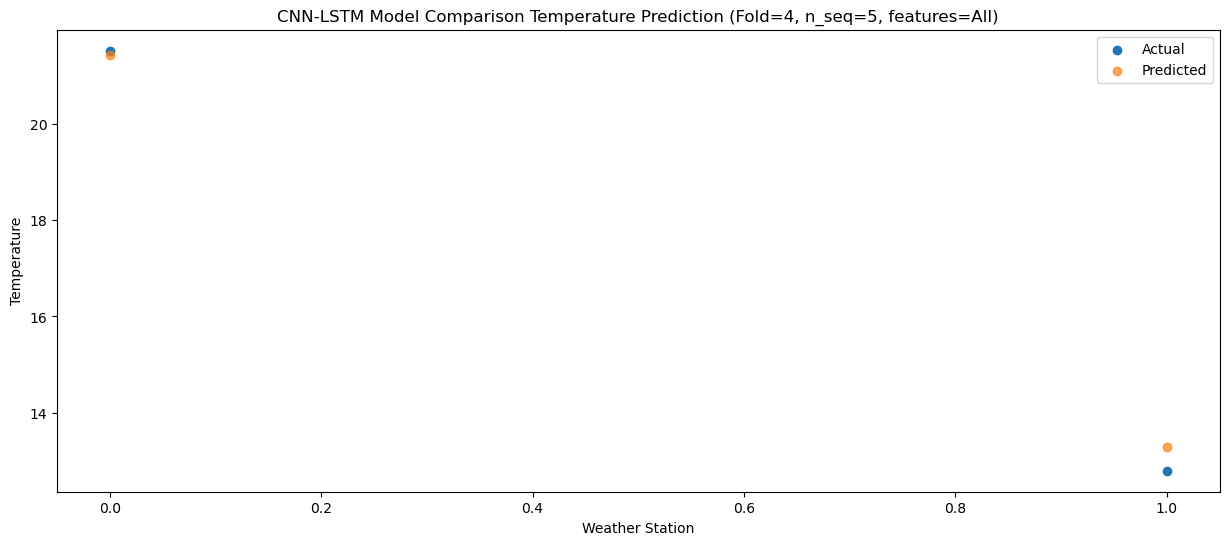

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   21.11  21.443123
1                1   13.11  13.346373


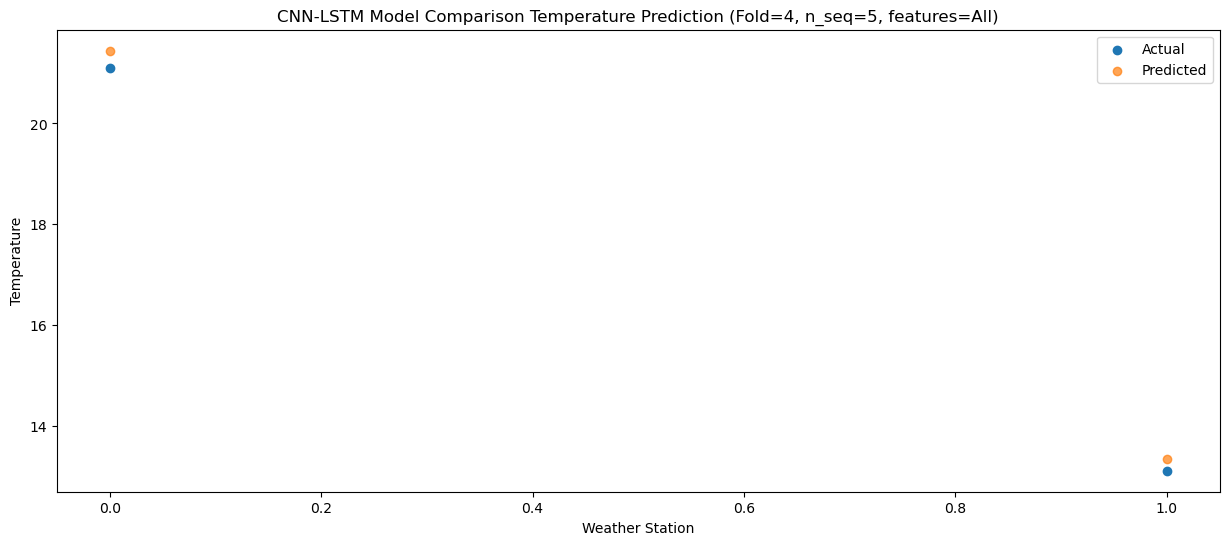

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.61  20.745024
1                1   12.24  12.560083


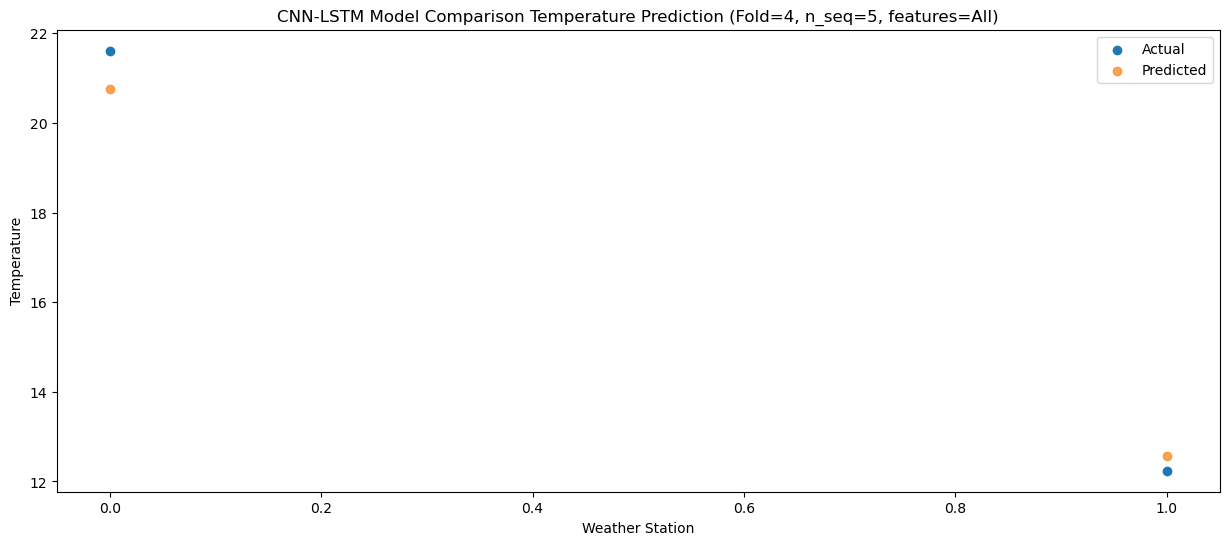

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   22.54  21.357061
1                1   13.72  13.218686


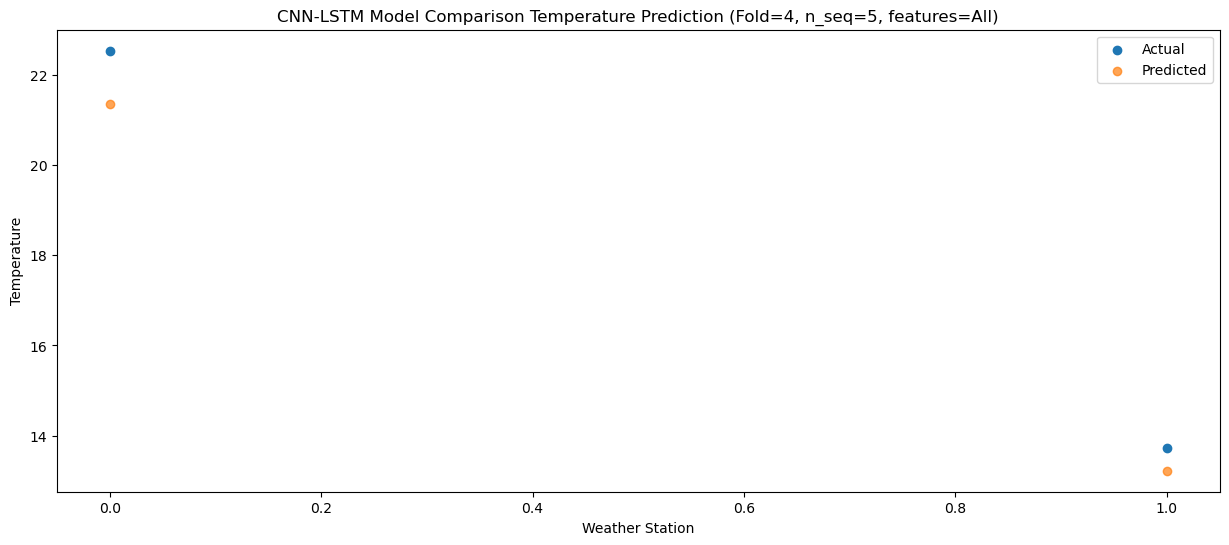

f, t:
[[21.01 12.23]
 [21.53 12.79]
 [21.11 13.11]
 [21.61 12.24]
 [22.54 13.72]]
[[20.94065247 12.6828128 ]
 [21.43636854 13.28830396]
 [21.4431233  13.34637323]
 [20.7450244  12.56008348]
 [21.35706075 13.21868637]]
Year at t+1:
t+1 SKRMSE: 0.323920
t+1 KRMSE: 0.323920
t+1 MAE: 0.261080
t+1 SKMAPE: 0.020163
t+1 R2_SCORE: 0.994556
t+1 KMAPE: 0.020163
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.358520
t+2 KRMSE: 0.358520
t+2 MAE: 0.295968
t+2 SKMAPE: 0.021655
t+2 R2_SCORE: 0.993269
t+2 KMAPE: 0.021655
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.288828
t+3 KRMSE: 0.288828
t+3 MAE: 0.284748
t+3 SKMAPE: 0.016905
t+3 R2_SCORE: 0.994786
t+3 KMAPE: 0.016905
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.652164
t+4 KRMSE: 0.652164
t+4 MAE: 0.592530
t+4 SKMAPE: 0.033089
t+4 R2_SCORE: 0.980623
t+4 KMAPE: 0.033089
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.908477
t+5 KRMSE: 0.908477
t+5 MAE: 0.842126
t+5 SKMAPE: 0.044510
t+5 R2_SCORE: 0.957562
t+5 KMAPE: 0.044510
t+5 PEARSON: 1

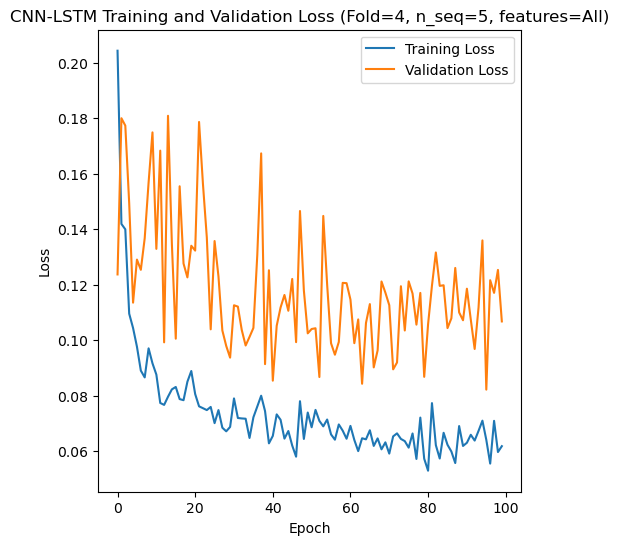

[[0.7146925713720435], [0.4713381094835772], [1.099174157023742], [0.4611394947627801], [0.5599162869880485]]
[[array(0.71469257)], [array(0.47133811)], [array(1.09917416)], [array(0.46113949)], [array(0.55991629)]]
[[0.6381172698792081], [0.3828523761183032], [0.9546019577682012], [0.3637880593277519], [0.4552904239110651]]
[[0.03563770605213635], [0.01922725121407177], [0.0627168458676642], [0.025099546631467313], [0.027264303662553408]]
[[0.8954864170271172], [0.4415069146784387], [0.6053518212238591], [-1.4662464468137886], [0.9838486000294747]]
[[array(0.03563771)], [array(0.01922725)], [array(0.06271685)], [array(0.02509955)], [array(0.0272643)]]
[[array(0.94819617)], [array(0.50732866)], [array(0.90286101)], [array(0.27092172)], [array(0.98845189)]]
[20.77 20.94 20.77 21.01 21.43 17.52 16.69 16.18 16.46 16.29 19.62 19.71
 18.79 19.13 19.97 19.82 20.34 19.95 19.95 21.26 17.6  16.9  17.14 17.11
 17.55 13.84 13.83 13.82 13.36 14.15 14.42 14.47 14.79 14.78 14.49 14.47
 14.35 14.15 1

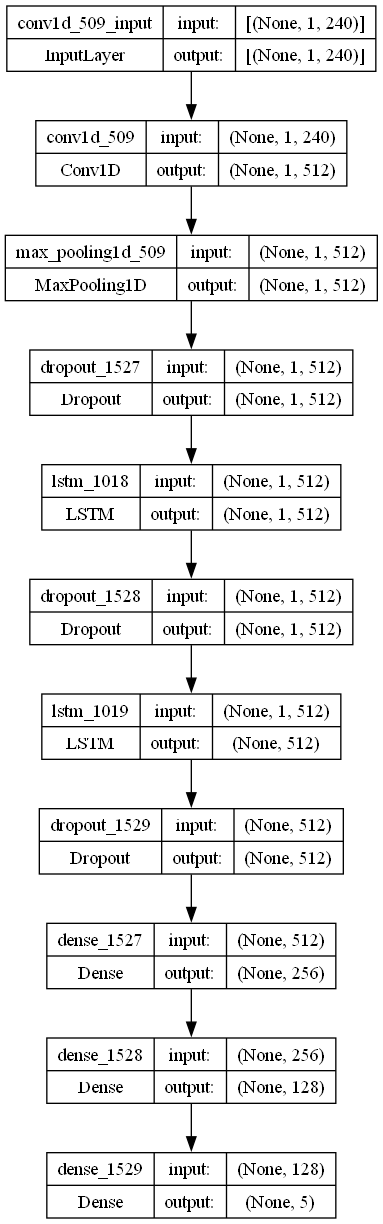

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 512
    lr = 0.0012981813030285164
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 512
    dropout_rate = 0.12065980367523137

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S5.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)